In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
import json

In [ ]:
!pip install --pre pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.9 M

In [ ]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 0


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:

i = 0
with h5py.File("/content/drive/MyDrive/per-protein.h5", "r") as file:
    print(f"number of entries: {len(file.items())}")
    for sequence_id, embedding in file.items():
        i += 1
        print(
            f"  id: {sequence_id}, "
            f"  embeddings shape: {embedding.shape}, "
            f"  embeddings mean: {np.array(embedding).mean()}"
        )
        if i == 10:
          break

number of entries: 571272
  id: A0A009IHW8,   embeddings shape: (1024,),   embeddings mean: -0.0008711814880371094
  id: A0A011QK89,   embeddings shape: (1024,),   embeddings mean: -0.00095367431640625
  id: A0A017SE81,   embeddings shape: (1024,),   embeddings mean: -0.0003161430358886719
  id: A0A017SE85,   embeddings shape: (1024,),   embeddings mean: -0.0011615753173828125
  id: A0A017SEF3,   embeddings shape: (1024,),   embeddings mean: 0.0008940696716308594
  id: A0A017SEX7,   embeddings shape: (1024,),   embeddings mean: -0.00021350383758544922
  id: A0A017SEY2,   embeddings shape: (1024,),   embeddings mean: -0.0007681846618652344
  id: A0A017SFB8,   embeddings shape: (1024,),   embeddings mean: -0.0002608299255371094
  id: A0A017SGC7,   embeddings shape: (1024,),   embeddings mean: -0.00025343894958496094
  id: A0A017SP50,   embeddings shape: (1024,),   embeddings mean: 0.0007491111755371094


In [ ]:
json_path = "/content/drive/MyDrive/protein_props.json"
with open(json_path) as f:
  data = json.load(f)
len(data)

20434

In [ ]:
okk = pd.read_json(json_path)
properties = okk.transpose()

In [ ]:
druggable_data = "/content/drive/MyDrive/druggable_proteins.txt"
with open(druggable_data) as f:
  druggable_proteins = [line.strip() for line in f]
print(len(druggable_proteins))

approved_drugs = "/content/drive/MyDrive/approved_druggable_proteins.txt"
with open(approved_drugs) as g:
  approved_proteins = [line.strip() for line in g]
print(len(approved_proteins))

3345
2652


In [ ]:
properties

Sequence Sequence Length  \
A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...             515   
A0A0B4J2F0  MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...              54   
A0A0B4J2F2  MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARH...             783   
A0A0C5B5G6                                   MRWQEMGYIFYPRKLR              16   
A0A0K2S4Q6  MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...             201   
...                                                       ...             ...   
Q9UI54      MESPKCLYSRITVNTAFGTKFSHISFIILFKVFLFPRITISKKTKL...              55   
Q9UI72      MGMALELYWLCGFRSYWPLGTNAENEGNRKENRRQMQSRNERGCNV...              69   
Q9Y3F1      MSLLWTPQILTISFVSYILSLFPSPFPSCYTSCWFETSITTEKELN...              56   
Q9Y6C7      MAHHSLNTFYIWHNNVLHTHLVFFLPHLLNQPFSRGSFLIWLLLCW...              94   
Q9Y6Z2      MGTAVGPHHSPAPHDSALPARLLTSDFPYGRSCQIEQVKYSVPDTG...              57   

           Molecular Weight     GRAVY  \
A0A087X1C5       57488.0269 -0.016117   
A0A0B4J2F0        6313.3024 -0.235185   
A0A0B4J2F2       84929.1856 -0.197957   
A0A0C5B5G6        2174.5917   -0.9375   
A0A0K2S4Q6       21805.9293   0.10796   
...                     ...       ...   
Q9UI54             6386.613  0.303636   
Q9UI72            8249.2539 -1.015942   
Q9Y3F1            6534.5215  0.444643   
Q9Y6C7           11023.7471 -0.029787   
Q9Y6Z2            6188.8293 -0.421053   

                                             Amino Acid Count  \
A0A087X1C5  {'A': 42, 'C': 9, 'D': 23, 'E': 28, 'F': 31, '...   
A0A0B4J2F0  {'A': 4, 'C': 0, 'D': 1, 'E': 6, 'F': 5, 'G': ...   
A0A0B4J2F2  {'A': 66, 'C': 19, 'D': 30, 'E': 43, 'F': 28, ...   
A0A0C5B5G6  {'A': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 1, 'G': ...   
A0A0K2S4Q6  {'A': 11, 'C': 8, 'D': 7, 'E': 10, 'F': 6, 'G'...   
...                                                       ...   
Q9UI54      {'A': 1, 'C': 1, 'D': 0, 'E': 1, 'F': 6, 'G': ...   
Q9UI72      {'A': 4, 'C': 3, 'D': 2, 'E': 6, 'F': 2, 'G': ...   
Q9Y3F1      {'A': 2, 'C': 2, 'D': 0, 'E': 4, 'F': 6, 'G': ...   
Q9Y6C7      {'A': 4, 'C': 2, 'D': 1, 'E': 1, 'F': 5, 'G': ...   
Q9Y6Z2      {'A': 4, 'C': 1, 'D': 3, 'E': 2, 'F': 2, 'G': ...   

                                           Amino Acid Percent  \
A0A087X1C5  {'A': 0.081553398058252, 'C': 0.01747572815533...   
A0A0B4J2F0  {'A': 0.074074074074074, 'C': 0.0, 'D': 0.0185...   
A0A0B4J2F2  {'A': 0.08429118773946301, 'C': 0.024265644955...   
A0A0C5B5G6  {'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0625, 'F...   
A0A0K2S4Q6  {'A': 0.054726368159203, 'C': 0.03980099502487...   
...                                                       ...   
Q9UI54      {'A': 0.018181818181818, 'C': 0.01818181818181...   
Q9UI72      {'A': 0.057971014492753006, 'C': 0.04347826086...   
Q9Y3F1      {'A': 0.035714285714285005, 'C': 0.03571428571...   
Q9Y6C7      {'A': 0.042553191489361, 'C': 0.02127659574468...   
Q9Y6Z2      {'A': 0.070175438596491, 'C': 0.01754385964912...   

           Molar Extinction Coefficient Isoelectric Point Instability Index  \
A0A087X1C5               [47440, 47940]          8.703506         45.155922   
A0A0B4J2F0                 [2980, 2980]           8.03542         55.518519   
A0A0B4J2F2               [56840, 57965]          6.813029         59.277803   
A0A0C5B5G6                 [8480, 8480]         10.266413         77.300625   
A0A0K2S4Q6               [33460, 33960]          5.366988         41.796517   
...                                 ...               ...               ...   
Q9UI54                     [2980, 2980]         10.302902         35.789091   
Q9UI72                   [15470, 15595]          9.348383         46.171014   
Q9Y3F1                   [15470, 15595]          4.493088            69.675   
Q9Y6C7                   [24980, 25105]         10.192468         62.375638   
Q9Y6Z2                     [8480, 8480]          5.982781              50.3   

           Aromaticity                                Secondary Structure  \

In [ ]:
glycolisation_path = "/content/drive/MyDrive/glycosylation.csv"
glycolisation = pd.read_csv(glycolisation_path)

ptm_path = "/content/drive/MyDrive/PTM_counts.csv"
ptm = pd.read_csv(ptm_path)

ppi_path = "/content/drive/MyDrive/ppi.json"
ppi = pd.read_json(ppi_path)
ppi = ppi.transpose()

In [ ]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20434 entries, A0A087X1C5 to Q9Y6Z2
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Sequence                      20434 non-null  object
 1   Sequence Length               20434 non-null  object
 2   Molecular Weight              20434 non-null  object
 3   GRAVY                         20434 non-null  object
 4   Amino Acid Count              20434 non-null  object
 5   Amino Acid Percent            20434 non-null  object
 6   Molar Extinction Coefficient  20434 non-null  object
 7   Isoelectric Point             20434 non-null  object
 8   Instability Index             20434 non-null  object
 9   Aromaticity                   20434 non-null  object
 10  Secondary Structure           20434 non-null  object
 11  Flexibility                   20434 non-null  object
 12  Charge at 7                   20434 non-null  object
dtypes: object(1

In [ ]:
embeddings = []
embedding_means = []

with h5py.File("/content/drive/MyDrive/per-protein.h5", "r") as file:
    for protein_id in properties.index:
        if protein_id in file:
            embedding = file[protein_id][()]
            embedding_mean = embedding.mean()
        else:
            embedding = np.nan
            embedding_mean = np.nan
        embeddings.append(embedding)
        embedding_means.append(embedding_mean)

# Add the embeddings and embedding means as new columns to the DataFrame
properties['embeddings'] = embeddings
properties['embedding_mean'] = embedding_means

In [ ]:
ptm

Unnamed: 0  Glycosylation  Cross-link  Modified residue  Signal  \
0      A0A087X1C5              1           0                 0       0   
1      A0A0B4J2F0              0           0                 0       0   
2      A0A0B4J2F2              0           0                 0       0   
3      A0A0C5B5G6              0           0                 0       0   
4      A0A0K2S4Q6              1           0                 0       1   
...           ...            ...         ...               ...     ...   
20429      Q9UI54              0           0                 0       0   
20430      Q9UI72              0           0                 0       0   
20431      Q9Y3F1              0           0                 0       0   
20432      Q9Y6C7              0           0                 0       0   
20433      Q9Y6Z2              0           0                 0       0   

       Disulfide bond  
0                   0  
1                   0  
2                   0  
3                   0  
4                   1  
...               ...  
20429               0  
20430               0  
20431               0  
20432               0  
20433               0  

[20434 rows x 6 columns]

In [ ]:
glycolisation

Unnamed: 0  O-linked  N-linked  C-linked  N-beta-linked  S-linked  \
0      A0A087X1C5         0         1         0              0         0   
1      A0A0B4J2F0         0         0         0              0         0   
2      A0A0B4J2F2         0         0         0              0         0   
3      A0A0C5B5G6         0         0         0              0         0   
4      A0A0K2S4Q6         0         1         0              0         0   
...           ...       ...       ...       ...            ...       ...   
20429      Q9UI54         0         0         0              0         0   
20430      Q9UI72         0         0         0              0         0   
20431      Q9Y3F1         0         0         0              0         0   
20432      Q9Y6C7         0         0         0              0         0   
20433      Q9Y6Z2         0         0         0              0         0   

       O-alpha-linked  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
20429               0  
20430               0  
20431               0  
20432               0  
20433               0  

[20434 rows x 7 columns]

In [ ]:
merged_df = pd.merge(ptm, glycolisation, on='Unnamed: 0')

In [ ]:
merged_df.set_index('Unnamed: 0', inplace=True)

In [ ]:
merged_df

Glycosylation  Cross-link  Modified residue  Signal  \
Unnamed: 0                                                        
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
Unnamed: 0                                                                
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  O-alpha-linked  
Unnamed: 0                            
A0A087X1C5         0               0  
A0A0B4J2F0         0               0  
A0A0B4J2F2         0               0  
A0A0C5B5G6         0               0  
A0A0K2S4Q6         0               0  
...              ...             ...  
Q9UI54             0               0  
Q9UI72             0               0  
Q9Y3F1             0               0  
Q9Y6C7             0               0  
Q9Y6Z2             0               0  

[20434 rows x 11 columns]

In [ ]:
final_df = pd.merge(merged_df, properties, left_index=True, right_index=True)

In [ ]:
ppi

binary_count  binary_experimental_count  xeno_count  \
P24821             2                          6           0   
Q96PT4             0                          0           0   
P62879            31                        116           0   
Q01664            14                         50           0   
Q9GZK3             0                          0           0   
...              ...                        ...         ...   
O75461             5                         49           0   
Q92911             2                          6           0   
Q9BQK8             0                          0           0   
Q99685             1                          2           0   
Q9ULZ9             0                          0           0   

        xeno_experimental_count  
P24821                        0  
Q96PT4                        0  
P62879                        0  
Q01664                        0  
Q9GZK3                        0  
...                         ...  
O75461                        0  
Q92911                        0  
Q9BQK8                        0  
Q99685                        0  
Q9ULZ9                        0  

[20434 rows x 4 columns]

In [ ]:
properties_df = pd.merge(final_df, ppi, left_index=True, right_index=True)

In [ ]:
properties_df

Glycosylation  Cross-link  Modified residue  Signal  \
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  ...  Aromaticity  \
A0A087X1C5         0  ...     0.085437   
A0A0B4J2F0         0  ...      0.12963   
A0A0B4J2F2         0  ...     0.063857   
A0A0C5B5G6         0  ...         0.25   
A0A0K2S4Q6         0  ...     0.074627   
...              ...  ...          ...   
Q9UI54             0  ...     0.145455   
Q9UI72             0  ...     0.101449   
Q9Y3F1             0  ...     0.196429   
Q9Y6C7             0  ...     0.117021   
Q9Y6Z2             0  ...     0.087719   

                                          Secondary Structure  \
A0A087X1C5  [0.31456310679611604, 0.262135922330097, 0.378...   
A0A0B4J2F0  [0.44444444444444403, 0.129629629629629, 0.388...   
A0A0B4J2F2  [0.314176245210727, 0.31289910600255405, 0.328...   
A0A0C5B5G6                             [0.3125, 0.125, 0.375]   
A0A0K2S4Q6  [0.283582089552238, 0.308457711442786, 0.40298...   
...                                                       ...   
Q9UI54      [0.29090909090909, 0.218181818181818, 0.527272...   
Q9UI72      [0.30434782608695604, 0.24637681159420202, 0.2...   
Q9Y3F1      [0.30357142857142805, 0.232142857142857, 0.535...   
Q9Y6C7      [0.319148936170212, 0.24468085106382903, 0.436...   
Q9Y6Z2      [0.210526315789473, 0.36842105263157804, 0.315...   

                                                  Flexibility Charge at 7  \
A0A087X1C5  [0.977440476190476, 0.9806071428571421, 0.9983...    5.889114   
A0A0B4J2F0  [0.982095238095238, 0.95625, 0.983214285714285...    0.510326   
A0A0B4J2F2  [1.00125, 0.970071428571428, 1.034523809523809...   -1.004586   
A0A0C5B5G6  [0.9704047619047621, 1.00345238095238, 0.95860...    2.500138   
A0A0K2S4Q6  [1.008285714285714, 0.9868928571428571, 0.991,...   -3.378625   
...                                                       ...         ...   
Q9UI54      [0.9746904761904761, 1.00325, 0.98202380952380...    7.571427   
Q9UI72      [1.006333333333333, 0.9435238095238091, 0.9573...    3.659009   
Q9Y3F1      [0.988154761904761, 0.9863214285714281, 0.9781...     -2.5132   
Q9Y6C7      [0.9616666666666661, 1.001988095238095, 0.9683...    6.176832   
Q9Y6Z2      [1.00745238095238, 0.9976309523809521, 0.97805...   -2.154883   

                                                   embeddings embedding_mean  \
A0A087X1C5  [0.

In [ ]:
properties_df.isna().sum()

Glycosylation                   0
Cross-link                      0
Modified residue                0
Signal                          0
Disulfide bond                  0
O-linked                        0
N-linked                        0
C-linked                        0
N-beta-linked                   0
S-linked                        0
O-alpha-linked                  0
Sequence                        0
Sequence Length                 0
Molecular Weight                0
GRAVY                           0
Amino Acid Count                0
Amino Acid Percent              0
Molar Extinction Coefficient    0
Isoelectric Point               0
Instability Index               0
Aromaticity                     0
Secondary Structure             0
Flexibility                     0
Charge at 7                     0
embeddings                      3
embedding_mean                  3
binary_count                    0
binary_experimental_count       0
xeno_count                      0
xeno_experimen

In [ ]:
properties_df.dropna(inplace = True)
properties_df.isna().sum()

Glycosylation                   0
Cross-link                      0
Modified residue                0
Signal                          0
Disulfide bond                  0
O-linked                        0
N-linked                        0
C-linked                        0
N-beta-linked                   0
S-linked                        0
O-alpha-linked                  0
Sequence                        0
Sequence Length                 0
Molecular Weight                0
GRAVY                           0
Amino Acid Count                0
Amino Acid Percent              0
Molar Extinction Coefficient    0
Isoelectric Point               0
Instability Index               0
Aromaticity                     0
Secondary Structure             0
Flexibility                     0
Charge at 7                     0
embeddings                      0
embedding_mean                  0
binary_count                    0
binary_experimental_count       0
xeno_count                      0
xeno_experimen

In [ ]:
is_druggable = []
for i in properties_df.index:
  if i in druggable_proteins:
    is_druggable.append(1)
  else:
    is_druggable.append(0)

approved_drugs = []
for j in properties_df.index:
  if j in approved_proteins:
    approved_drugs.append(1)
  else:
    approved_drugs.append(0)

properties_df['is_druggable'] = is_druggable
properties_df['is_approved'] = approved_drugs
properties_df


Glycosylation  Cross-link  Modified residue  Signal  \
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  ...                                        Flexibility  \
A0A087X1C5         0  ...  [0.977440476190476, 0.9806071428571421, 0.9983...   
A0A0B4J2F0         0  ...  [0.982095238095238, 0.95625, 0.983214285714285...   
A0A0B4J2F2         0  ...  [1.00125, 0.970071428571428, 1.034523809523809...   
A0A0C5B5G6         0  ...  [0.9704047619047621, 1.00345238095238, 0.95860...   
A0A0K2S4Q6         0  ...  [1.008285714285714, 0.9868928571428571, 0.991,...   
...              ...  ...                                                ...   
Q9UI54             0  ...  [0.9746904761904761, 1.00325, 0.98202380952380...   
Q9UI72             0  ...  [1.006333333333333, 0.9435238095238091, 0.9573...   
Q9Y3F1             0  ...  [0.988154761904761, 0.9863214285714281, 0.9781...   
Q9Y6C7             0  ...  [0.9616666666666661, 1.001988095238095, 0.9683...   
Q9Y6Z2             0  ...  [1.00745238095238, 0.9976309523809521, 0.97805...   

           Charge at 7                                         embeddings  \
A0A087X1C5    5.889114  [0.004597, 0.0673, 0.001243, -0.02876, -0.0549...   
A0A0B4J2F0    0.510326  [0.0575, -0.04382, -0.003994, -0.00574, 0.0502...   
A0A0B4J2F2   -1.004586  [0.00659, 0.02846, 0.01593, 0.002148, -0.03137...   
A0A0C5B5G6    2.500138  [0.11304, 0.04965, -0.11035, -0.1404, 0.02875,...   
A0A0K2S4Q6   -3.378625  [-0.012955, 0.02867, 0.06024, 0.01366, -0.0169...   
...                ...                                                ...   
Q9UI54        7.571427  [0.0974, 0.0672, -0.0671, -0.01249, -0.05167, ...   
Q9UI72        3.659009  [0.04962, 0.05548, 0.03693, -0.006916, -0.0482...   
Q9Y3F1         -2.5132  [0.05945, 0.1229, -0.04916, 0.02313, -0.1155, ...   
Q9Y6C7        6.176832  [0.01464, 0.0842, 0.01442, 0.0569, -0.0837, -0...   
Q9Y6Z2       -2.154883  [0.0833, 0.06274, -0.005722, -0.01752, -0.1235...   

           embedding_mean binary_count binary_experimental_count xeno_count  \
A0A087X1C5       0.000403            0                         0          0   
A0A0B4J2F0      -0.001044            1                        11          0   
A0A0B4J2F2      -0.000118            6                        18          0   
A0A0C5B5G6      -0.000869            0                         0          0   
A0A0K2S4Q6       0.000732

In [ ]:
#lets see how well embeddings alone can identify druggable or not

embeddings_data = pd.DataFrame({'embeddings': properties_df['embeddings'], 'is_druggable':properties_df['is_druggable'] })
embeddings_data

embeddings  is_druggable
A0A087X1C5  [0.004597, 0.0673, 0.001243, -0.02876, -0.0549...             0
A0A0B4J2F0  [0.0575, -0.04382, -0.003994, -0.00574, 0.0502...             0
A0A0B4J2F2  [0.00659, 0.02846, 0.01593, 0.002148, -0.03137...             0
A0A0C5B5G6  [0.11304, 0.04965, -0.11035, -0.1404, 0.02875,...             0
A0A0K2S4Q6  [-0.012955, 0.02867, 0.06024, 0.01366, -0.0169...             0
...                                                       ...           ...
Q9UI54      [0.0974, 0.0672, -0.0671, -0.01249, -0.05167, ...             0
Q9UI72      [0.04962, 0.05548, 0.03693, -0.006916, -0.0482...             0
Q9Y3F1      [0.05945, 0.1229, -0.04916, 0.02313, -0.1155, ...             0
Q9Y6C7      [0.01464, 0.0842, 0.01442, 0.0569, -0.0837, -0...             0
Q9Y6Z2      [0.0833, 0.06274, -0.005722, -0.01752, -0.1235...             0

[20431 rows x 2 columns]

In [ ]:
# applying PCA to dimensionally reduce embedding size

def reduce_embeddings(embeddings, target_dim):
    pca = PCA(n_components=target_dim)
    reduced_embeddings = pca.fit_transform(np.stack(embeddings))
    return reduced_embeddings

reduced_embeddings = reduce_embeddings(embeddings_data['embeddings'], 10)

In [ ]:
def test_results(y_pred, y_test):
    results = {}
    results['Accuracy'] = accuracy_score(y_test,y_pred)
    results['Precision'] = precision_score(y_test,y_pred,average = 'weighted')
    results['Recall'] = recall_score(y_test,y_pred,average = 'weighted')
    results['F1_Score'] = f1_score(y_test,y_pred,average = 'weighted')
    results['ROC_AUC'] = calculate_roc_auc(y_test, y_pred)

    cm = confusion_matrix(y_test,y_pred)
    return results, cm

In [ ]:
def calculate_roc_auc(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return auc

In [ ]:
embeddings_data['Extracted_Embeddings'] = reduced_embeddings.tolist()

In [ ]:
# Saving DataFrame to a CSV file
embeddings_data.to_csv('embeddings_data.csv', index=False)

In [ ]:
properties_df['extracted_embeddings'] = embeddings_data['Extracted_Embeddings']
properties_df

Glycosylation  Cross-link  Modified residue  Signal  \
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  ...  Charge at 7  \
A0A087X1C5         0  ...     5.889114   
A0A0B4J2F0         0  ...     0.510326   
A0A0B4J2F2         0  ...    -1.004586   
A0A0C5B5G6         0  ...     2.500138   
A0A0K2S4Q6         0  ...    -3.378625   
...              ...  ...          ...   
Q9UI54             0  ...     7.571427   
Q9UI72             0  ...     3.659009   
Q9Y3F1             0  ...      -2.5132   
Q9Y6C7             0  ...     6.176832   
Q9Y6Z2             0  ...    -2.154883   

                                                   embeddings embedding_mean  \
A0A087X1C5  [0.004597, 0.0673, 0.001243, -0.02876, -0.0549...       0.000403   
A0A0B4J2F0  [0.0575, -0.04382, -0.003994, -0.00574, 0.0502...      -0.001044   
A0A0B4J2F2  [0.00659, 0.02846, 0.01593, 0.002148, -0.03137...      -0.000118   
A0A0C5B5G6  [0.11304, 0.04965, -0.11035, -0.1404, 0.02875,...      -0.000869   
A0A0K2S4Q6  [-0.012955, 0.02867, 0.06024, 0.01366, -0.0169...       0.000732   
...                                                       ...            ...   
Q9UI54      [0.0974, 0.0672, -0.0671, -0.01249, -0.05167, ...      -0.000687   
Q9UI72      [0.04962, 0.05548, 0.03693, -0.006916, -0.0482...      -0.000281   
Q9Y3F1      [0.05945, 0.1229, -0.04916, 0.02313, -0.1155, ...      -0.000161   
Q9Y6C7      [0.01464, 0.0842, 0.01442, 0.0569, -0.0837, -0...       0.000837   
Q9Y6Z2      [0.0833, 0.06274, -0.005722, -0.01752, -0.1235...       0.000038   

           binary_count binary_experimental_count xeno_count  \
A0A087X1C5            0                         0          0   
A0A0B4J2F0            1                        11          0   
A0A0B4J2F2            6                        18          0   
A0A0C5B5G6            0                         0          0   
A0A0K2S4Q6            0                         0          0   
...                 ...                       ...        ...   
Q9UI54                0                         0          0   
Q9UI72                0                         0          0   
Q9Y3F1                0                         0          0   
Q9Y6C7                0                         0          0   
Q9Y6Z2                0                         0          0   

           xeno_experimental_count is_druggable is_approved  \
A0A087X1

In [ ]:
properties_df['extracted_embeddings'][0]

[-0.024966775093703823,
 0.1172725854118536,
 -0.33086454080067185,
 0.03792566173312654,
 -0.031852956420528496,
 0.2674464701777358,
 -0.08522980465642457,
 -0.021348292372844337,
 0.16135992257220572,
 -0.02506446274864061]

In [ ]:
for i in range(10):
  properties_df[f'embeddings_{i}'] = pd.Series([0]*properties_df.shape[0])
for j in range(properties_df.shape[0]):
  for n,k in enumerate(properties_df['extracted_embeddings'][j]):
    properties_df[f'embeddings_{n}'][j] = k

properties_df

Streaming output truncated to the last 5000 lines.
<ipython-input-33-952e3d8aff98>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties_df[f'embeddings_{n}'][j] = k
<ipython-input-33-952e3d8aff98>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties_df[f'embeddings_{n}'][j] = k
<ipython-input-33-952e3d8aff98>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties_df[f'embeddings_{n}'][j] = k
<ipython-input-33-952e3d8

Glycosylation  Cross-link  Modified residue  Signal  \
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  ...  embeddings_0 embeddings_1 embeddings_2  \
A0A087X1C5         0  ...     -0.024967     0.117273    -0.330865   
A0A0B4J2F0         0  ...     -0.229125    -0.075254    -0.096526   
A0A0B4J2F2         0  ...      0.069026    -0.106894     0.145064   
A0A0C5B5G6         0  ...      0.344685    -0.059563     0.131865   
A0A0K2S4Q6         0  ...      0.201803    -0.020062    -0.831335   
...              ...  ...           ...          ...          ...   
Q9UI54             0  ...      0.782220     0.153387     0.365621   
Q9UI72             0  ...      1.062770     0.276550     0.398023   
Q9Y3F1             0  ...      0.867031     0.135837     0.260897   
Q9Y6C7             0  ...      0.945441     0.094274     0.347996   
Q9Y6Z2             0  ...      0.794496    -0.060411     0.252894   

           embeddings_3 embeddings_4 embeddings_5 embeddings_6 embeddings_7  \
A0A087X1C5     0.037926    -0.031853     0.267446    -0.085230    -0.021348   
A0A0B4J2F0     0.142884     0.282363    -0.430086     0.314226    -0.151583   
A0A0B4J2F2     0.134980    -0.220885     0.052561    -0.274148     0.052862   
A0A0C5B5G6     0.728027     1.233446    -0.256274     0.214893     0.423912   
A0A0K2S4Q6     0.117412    -0.180060     0.005536     0.033790    -0.036385   
...                 ...          ...          ...          ...          ...   
Q9UI54         0.528140     1.107544     0.033328    -0.118226     0.275996   
Q9UI72         0.596185     0.854038     0.028776     0.046054     0.172400   
Q9Y3F1         0.665645     1.035670     0.091707     0.010887     0.462760   
Q9Y6C7         0.597375     1.042889     0.169315    -0.010502     0.371875   
Q9Y6Z2         0.690065     0.784035     0.031419    -0.033837     0.333490   

           embeddings_8 embeddings_9  
A0A087X1C5     0.161360    -0.025064  
A0A0B4J2F0     0.254937    -0.042167  
A0A0B4J2F2     0.124378    -0.037147  
A0A0C5B5G6    -0.028761    -0.461087  
A0A0K2S4Q6    -0.098711     0.032851  
...                 ...          ...  
Q9UI54        -0.232847    -0.165699  
Q9UI72        -0.408362    -0.446902  
Q9Y3F1        -0.149100    -0.199582  
Q9Y6C7        -0.081536    -0.118009  
Q9Y6Z2        -0.222323    -0.315643  

[20431 rows x 43 columns]

In [ ]:
properties_df.to_csv('properties_df.csv')

In [ ]:
# Load the dictionary from the JSON file
location_path = "/content/drive/MyDrive/subcellular_locations2.json"
with open(location_path, 'r') as file:
    data = json.load(file)

unique_groups = set()

for entry in data.values():
    if "general" in entry:
        for general_entry in entry["general"]:
            if "group" in general_entry:
                unique_groups.add(general_entry["group"])

unique_groups_list = list(unique_groups)

print(unique_groups_list)

['early endosome', 'membrane', 'inflammasome', 'cytoplasmic vesicle', 'vacuole', 'cytoplasmic granule', 'chromosome', 'mitochondrion', 'cell surface', 'myelin membrane', 'vacuole membrane', 'endomembrane system', 'cell membrane', 'endoplasmic reticulum', 'golgi outpost', 'virion', 'presynapse', 'recycling endosome', 'target cell membrane', 'golgo apparatus', 'photoreceptor', 'zymogen granule', 'cell junction', 'midbody', 'extracellular vessicle', 'lateral cell membrane', 'secreted', 'dynein axonemal particle', 'endosome', 'cell projection', 'late endosome', 'sarcoplasmic reticulum', 'cornified envelope', 'cytoplasm', 'vesicle', 'perikaryon', 'melanosome', 'lipid droplet', 'lysosome', 'cleavage furrow', 'parasitophorous vacuole', 'synapse', 'cytolitic granule', 'postsynapse', 'preautophagosomal structure', 'rough endoplasmic reticulum', 'peroxisome', 'nucleus', 'smooth endoplasmic reticulum membrane', 'microsome']


In [ ]:
len(unique_groups_list)

50

In [ ]:
for group in unique_groups_list:
    properties_df[group] = 0

    for protein_id in properties_df.index:
        if protein_id in data:
            for entry in data[protein_id].get("general", []):
                if "group" in entry and entry["group"] == group:
                    properties_df.at[protein_id, group] = 1

In [ ]:
properties_df

Glycosylation  Cross-link  Modified residue  Signal  \
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  ...  parasitophorous vacuole synapse cytolitic granule  \
A0A087X1C5         0  ...                        0       0                 0   
A0A0B4J2F0         0  ...                        0       0                 0   
A0A0B4J2F2         0  ...                        0       0                 0   
A0A0C5B5G6         0  ...                        0       0                 0   
A0A0K2S4Q6         0  ...                        0       0                 0   
...              ...  ...                      ...     ...               ...   
Q9UI54             0  ...                        0       0                 0   
Q9UI72             0  ...                        0       0                 0   
Q9Y3F1             0  ...                        0       0                 0   
Q9Y6C7             0  ...                        0       0                 0   
Q9Y6Z2             0  ...                        0       0                 0   

           postsynapse preautophagosomal structure  \
A0A087X1C5           0                           0   
A0A0B4J2F0           0                           0   
A0A0B4J2F2           0                           0   
A0A0C5B5G6           0                           0   
A0A0K2S4Q6           0                           0   
...                ...                         ...   
Q9UI54               0                           0   
Q9UI72               0                           0   
Q9Y3F1               0                           0   
Q9Y6C7               0                           0   
Q9Y6Z2               0                           0   

           rough endoplasmic reticulum peroxisome nucleus  \
A0A087X1C5                           0          0       0   
A0A0B4J2F0                           0          0       0   
A0A0B4J2F2                           0          0       0   
A0A0C5B5G6                           0          0       1   
A0A0K2S4Q6                           0          0       0   
...                                ...        ...     ...   
Q9UI54                               0          0       0   
Q9UI72                               0          0       0   
Q9Y3F1                               0          0       0   
Q9Y6C7                               0          0       0   
Q9Y6Z2                   

In [ ]:
properties_df.columns

Index(['Glycosylation', 'Cross-link', 'Modified residue', 'Signal',
       'Disulfide bond', 'O-linked', 'N-linked', 'C-linked', 'N-beta-linked',
       'S-linked', 'O-alpha-linked', 'Sequence', 'Sequence Length',
       'Molecular Weight', 'GRAVY', 'Amino Acid Count', 'Amino Acid Percent',
       'Molar Extinction Coefficient', 'Isoelectric Point',
       'Instability Index', 'Aromaticity', 'Secondary Structure',
       'Flexibility', 'Charge at 7', 'embeddings', 'embedding_mean',
       'binary_count', 'binary_experimental_count', 'xeno_count',
       'xeno_experimental_count', 'is_druggable', 'is_approved',
       'extracted_embeddings', 'embeddings_0', 'embeddings_1', 'embeddings_2',
       'embeddings_3', 'embeddings_4', 'embeddings_5', 'embeddings_6',
       'embeddings_7', 'embeddings_8', 'embeddings_9', 'early endosome',
       'membrane', 'inflammasome', 'cytoplasmic vesicle', 'vacuole',
       'cytoplasmic granule', 'chromosome', 'mitochondrion', 'cell surface',
       'myeli

In [ ]:
properties_df

Glycosylation  Cross-link  Modified residue  Signal  \
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  ...  parasitophorous vacuole synapse cytolitic granule  \
A0A087X1C5         0  ...                        0       0                 0   
A0A0B4J2F0         0  ...                        0       0                 0   
A0A0B4J2F2         0  ...                        0       0                 0   
A0A0C5B5G6         0  ...                        0       0                 0   
A0A0K2S4Q6         0  ...                        0       0                 0   
...              ...  ...                      ...     ...               ...   
Q9UI54             0  ...                        0       0                 0   
Q9UI72             0  ...                        0       0                 0   
Q9Y3F1             0  ...                        0       0                 0   
Q9Y6C7             0  ...                        0       0                 0   
Q9Y6Z2             0  ...                        0       0                 0   

           postsynapse preautophagosomal structure  \
A0A087X1C5           0                           0   
A0A0B4J2F0           0                           0   
A0A0B4J2F2           0                           0   
A0A0C5B5G6           0                           0   
A0A0K2S4Q6           0                           0   
...                ...                         ...   
Q9UI54               0                           0   
Q9UI72               0                           0   
Q9Y3F1               0                           0   
Q9Y6C7               0                           0   
Q9Y6Z2               0                           0   

           rough endoplasmic reticulum peroxisome nucleus  \
A0A087X1C5                           0          0       0   
A0A0B4J2F0                           0          0       0   
A0A0B4J2F2                           0          0       0   
A0A0C5B5G6                           0          0       1   
A0A0K2S4Q6                           0          0       0   
...                                ...        ...     ...   
Q9UI54                               0          0       0   
Q9UI72                               0          0       0   
Q9Y3F1                               0          0       0   
Q9Y6C7                               0          0       0   
Q9Y6Z2                   

In [ ]:
index = 'A C D E F G H I K L M N P Q R S T V W Y'
for i in index.split(" "):
  properties_df[f"Amino_Acid_{i}_Percent"] = pd.Series([0]*properties_df.shape[0])
properties_df['Molar Extinction Coefficient 1'] = pd.Series([0]*properties_df.shape[0])
properties_df['Molar Extinction Coefficient 2'] = pd.Series([0]*properties_df.shape[0])
properties_df['Secondary Structure helix'] = pd.Series([0]*properties_df.shape[0])
properties_df['Secondary Structure turn'] = pd.Series([0]*properties_df.shape[0])
properties_df['Secondary Structure sheet'] = pd.Series([0]*properties_df.shape[0])
for i in range(properties_df.shape[0]):
  for j,k in properties_df['Amino Acid Percent'][i].items():
    properties_df[f"Amino_Acid_{j}_Percent"][i] = k
  properties_df['Molar Extinction Coefficient 1'][i] = properties_df['Molar Extinction Coefficient'][i][0]
  properties_df['Molar Extinction Coefficient 2'][i] = properties_df['Molar Extinction Coefficient'][i][1]
  properties_df['Secondary Structure helix'][i] = properties_df['Secondary Structure'][i][0]
  properties_df['Secondary Structure turn'][i] = properties_df['Secondary Structure'][i][1]
  properties_df['Secondary Structure sheet'][i] = properties_df['Secondary Structure'][i][2]
properties_df.drop(columns = ['Sequence','Sequence Length','Amino Acid Count','Amino Acid Percent','Molar Extinction Coefficient','Secondary Structure','embeddings','extracted_embeddings'],axis = 1, inplace = True)

Streaming output truncated to the last 5000 lines.
<ipython-input-41-2badab89bfd9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties_df[f"Amino_Acid_{j}_Percent"][i] = k
<ipython-input-41-2badab89bfd9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties_df[f"Amino_Acid_{j}_Percent"][i] = k
<ipython-input-41-2badab89bfd9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties_df[f"Amino_Acid_{j}_Percent"][i] = 

In [ ]:
properties_df

Glycosylation  Cross-link  Modified residue  Signal  \
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  ...  Amino_Acid_S_Percent Amino_Acid_T_Percent  \
A0A087X1C5         0  ...              0.048544             0.048544   
A0A0B4J2F0         0  ...              0.037037             0.037037   
A0A0B4J2F2         0  ...              0.085568             0.052363   
A0A0C5B5G6         0  ...              0.000000             0.000000   
A0A0K2S4Q6         0  ...              0.099502             0.084577   
...              ...  ...                   ...                  ...   
Q9UI54             0  ...              0.109091             0.109091   
Q9UI72             0  ...              0.028986             0.043478   
Q9Y3F1             0  ...              0.142857             0.107143   
Q9Y6C7             0  ...              0.085106             0.063830   
Q9Y6Z2             0  ...              0.105263             0.070175   

           Amino_Acid_V_Percent Amino_Acid_W_Percent Amino_Acid_Y_Percent  \
A0A087X1C5             0.085437             0.013592             0.011650   
A0A0B4J2F0             0.074074             0.000000             0.037037   
A0A0B4J2F2             0.053640             0.007663             0.020434   
A0A0C5B5G6             0.000000             0.062500             0.125000   
A0A0K2S4Q6             0.079602             0.024876             0.019900   
...                         ...                  ...                  ...   
Q9UI54                 0.054545             0.000000             0.036364   
Q9UI72                 0.014493             0.028986             0.043478   
Q9Y3F1                 0.017857             0.035714             0.053571   
Q9Y6C7                 0.031915             0.042553             0.021277   
Q9Y6Z2                 0.052632             0.017544             0.035088   

           Molar Extinction Coefficient 1 Molar Extinction Coefficient 2  \
A0A087X1C5                        47440.0                        47940.0   
A0A0B4J2F0                         2980.0                         2980.0   
A0A0B4J2F2                        56840.0                        57965.0   
A0A0C5B5G6                         8480.0                         8480.0   
A0A0K2S4Q6                        33460.0                        33960.0   
...                                   ...                   

In [ ]:
data = properties_df.drop(['Flexibility'],axis = 1)
data

Glycosylation  Cross-link  Modified residue  Signal  \
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  ...  Amino_Acid_S_Percent Amino_Acid_T_Percent  \
A0A087X1C5         0  ...              0.048544             0.048544   
A0A0B4J2F0         0  ...              0.037037             0.037037   
A0A0B4J2F2         0  ...              0.085568             0.052363   
A0A0C5B5G6         0  ...              0.000000             0.000000   
A0A0K2S4Q6         0  ...              0.099502             0.084577   
...              ...  ...                   ...                  ...   
Q9UI54             0  ...              0.109091             0.109091   
Q9UI72             0  ...              0.028986             0.043478   
Q9Y3F1             0  ...              0.142857             0.107143   
Q9Y6C7             0  ...              0.085106             0.063830   
Q9Y6Z2             0  ...              0.105263             0.070175   

           Amino_Acid_V_Percent Amino_Acid_W_Percent Amino_Acid_Y_Percent  \
A0A087X1C5             0.085437             0.013592             0.011650   
A0A0B4J2F0             0.074074             0.000000             0.037037   
A0A0B4J2F2             0.053640             0.007663             0.020434   
A0A0C5B5G6             0.000000             0.062500             0.125000   
A0A0K2S4Q6             0.079602             0.024876             0.019900   
...                         ...                  ...                  ...   
Q9UI54                 0.054545             0.000000             0.036364   
Q9UI72                 0.014493             0.028986             0.043478   
Q9Y3F1                 0.017857             0.035714             0.053571   
Q9Y6C7                 0.031915             0.042553             0.021277   
Q9Y6Z2                 0.052632             0.017544             0.035088   

           Molar Extinction Coefficient 1 Molar Extinction Coefficient 2  \
A0A087X1C5                        47440.0                        47940.0   
A0A0B4J2F0                         2980.0                         2980.0   
A0A0B4J2F2                        56840.0                        57965.0   
A0A0C5B5G6                         8480.0                         8480.0   
A0A0K2S4Q6                        33460.0                        33960.0   
...                                   ...                   

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20431 entries, A0A087X1C5 to Q9Y6Z2
Columns: 109 entries, Glycosylation to Secondary Structure sheet
dtypes: float64(36), int64(67), object(6)
memory usage: 17.7+ MB


In [ ]:
data.isna().sum().sum()

0

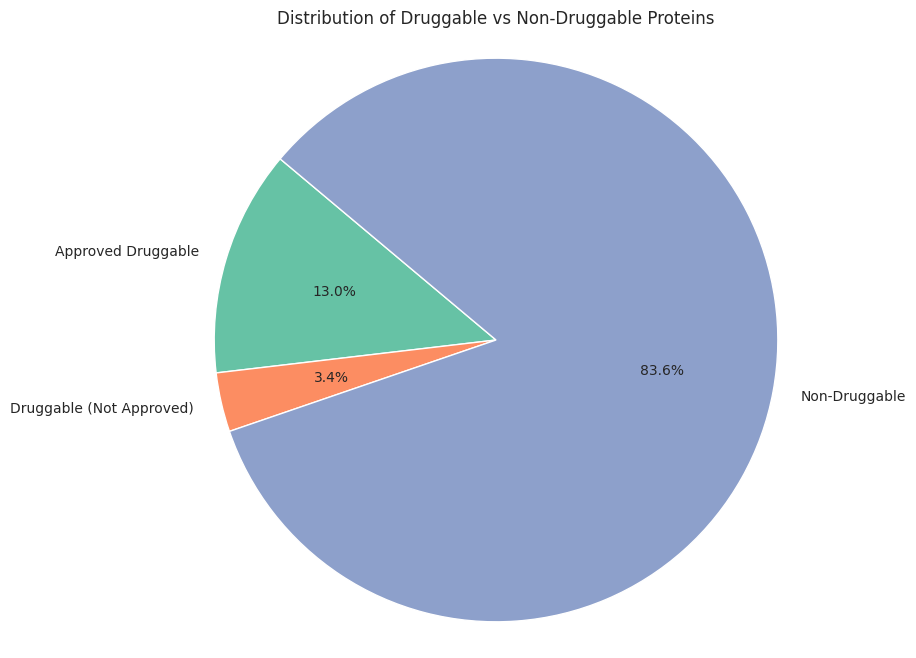

In [ ]:
druggable_counts = properties_df['is_druggable'].value_counts()

druggable_df = properties_df[properties_df['is_druggable'] == 1]
approved_druggable_count = druggable_df['is_approved'].sum()

total_proteins = properties_df.shape[0]

non_druggable_count = total_proteins - druggable_counts[1]
non_approved_druggable_count = druggable_counts[1] - approved_druggable_count

# Plotting
plt.figure(figsize=(8, 8))
plt.pie([approved_druggable_count, non_approved_druggable_count, non_druggable_count], labels=['Approved Druggable', 'Druggable (Not Approved)', 'Non-Druggable'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Distribution of Druggable vs Non-Druggable Proteins')
plt.axis('equal')
plt.show()

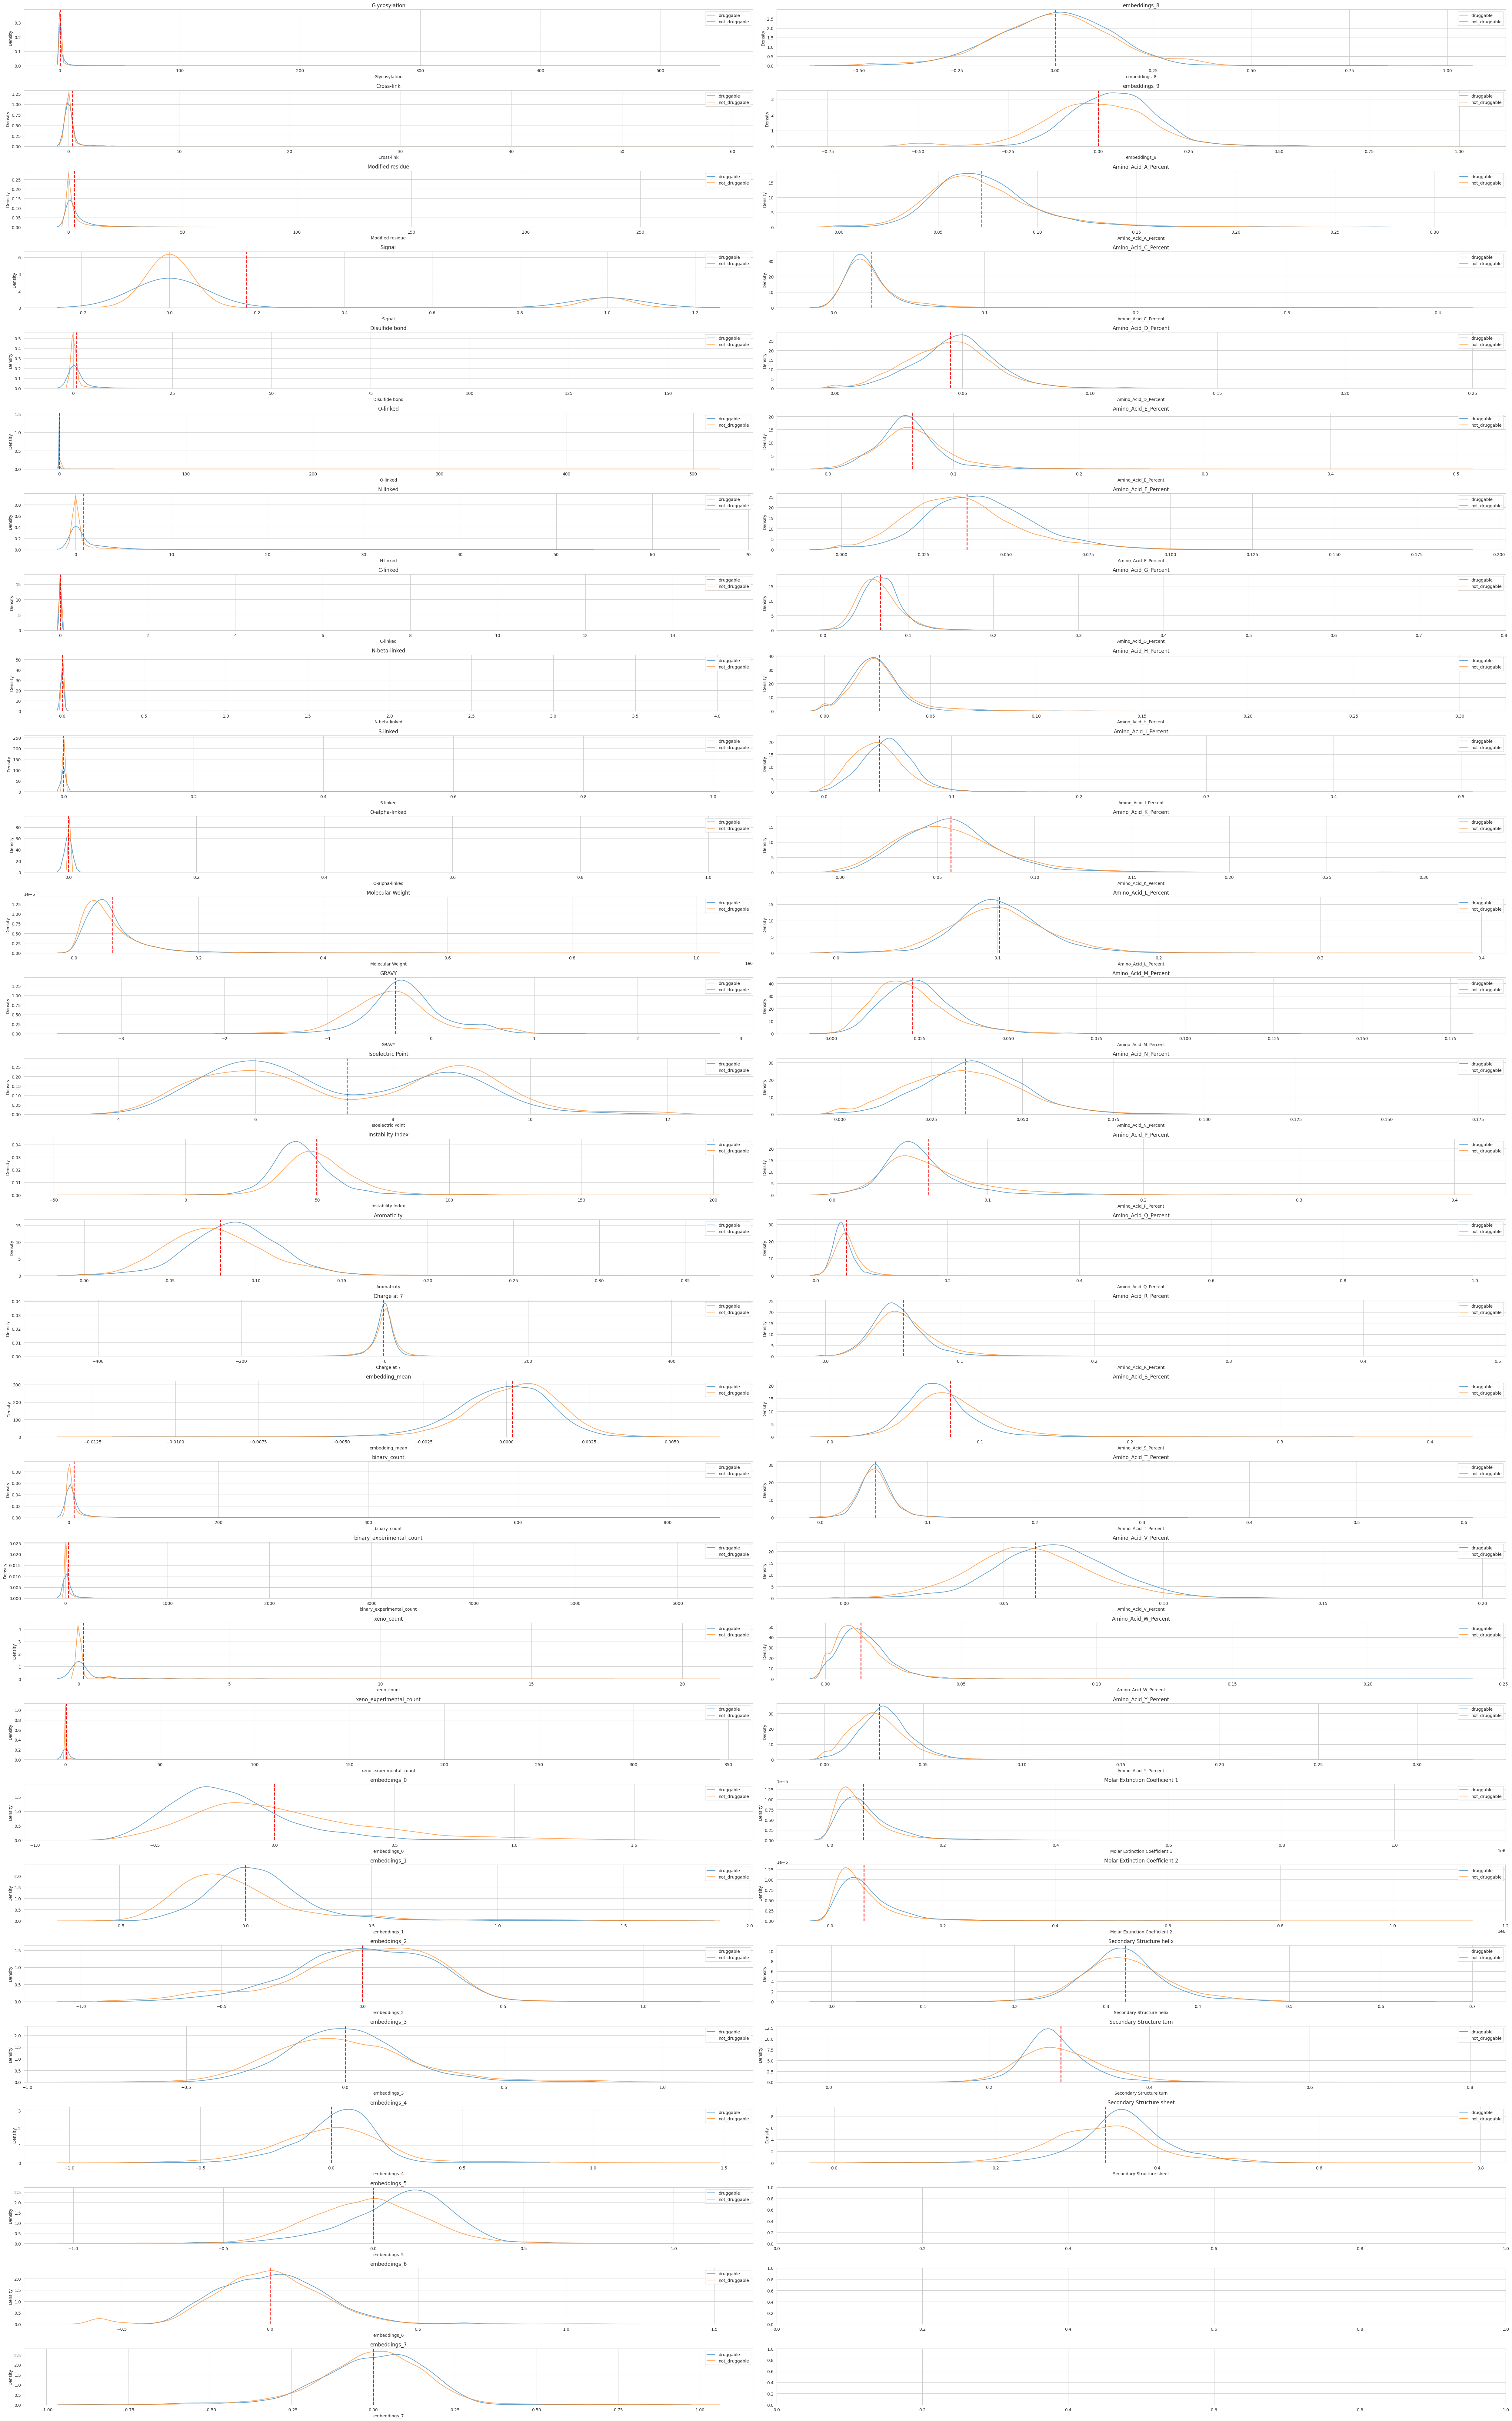

In [ ]:
fig,ax = plt.subplots(figsize = (50,80),nrows = 30,ncols = 2)
okk = [i for i in data.columns if i!= "is_druggable" and i!= "is_approved" and i not in unique_groups_list]
for i,values in enumerate(okk):
  if i <30:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label = 'druggable')
    sns.kdeplot(data = data[data['is_druggable'] == 0], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label ='not_druggable')
    ax[i][0].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i][0].set_title(values)
    ax[i][0].legend()
  else:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i-30][1],alpha = 0.7,common_norm = True,label = 'druggable')
    sns.kdeplot(data=data[data['is_druggable'] == 0], x=values, ax=ax[i-30][1],alpha = 0.7,common_norm = True,label ='not_druggable')
    ax[i-30][1].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i-30][1].set_title(values)
    ax[i-30][1].legend()

plt.tight_layout()
plt.show()

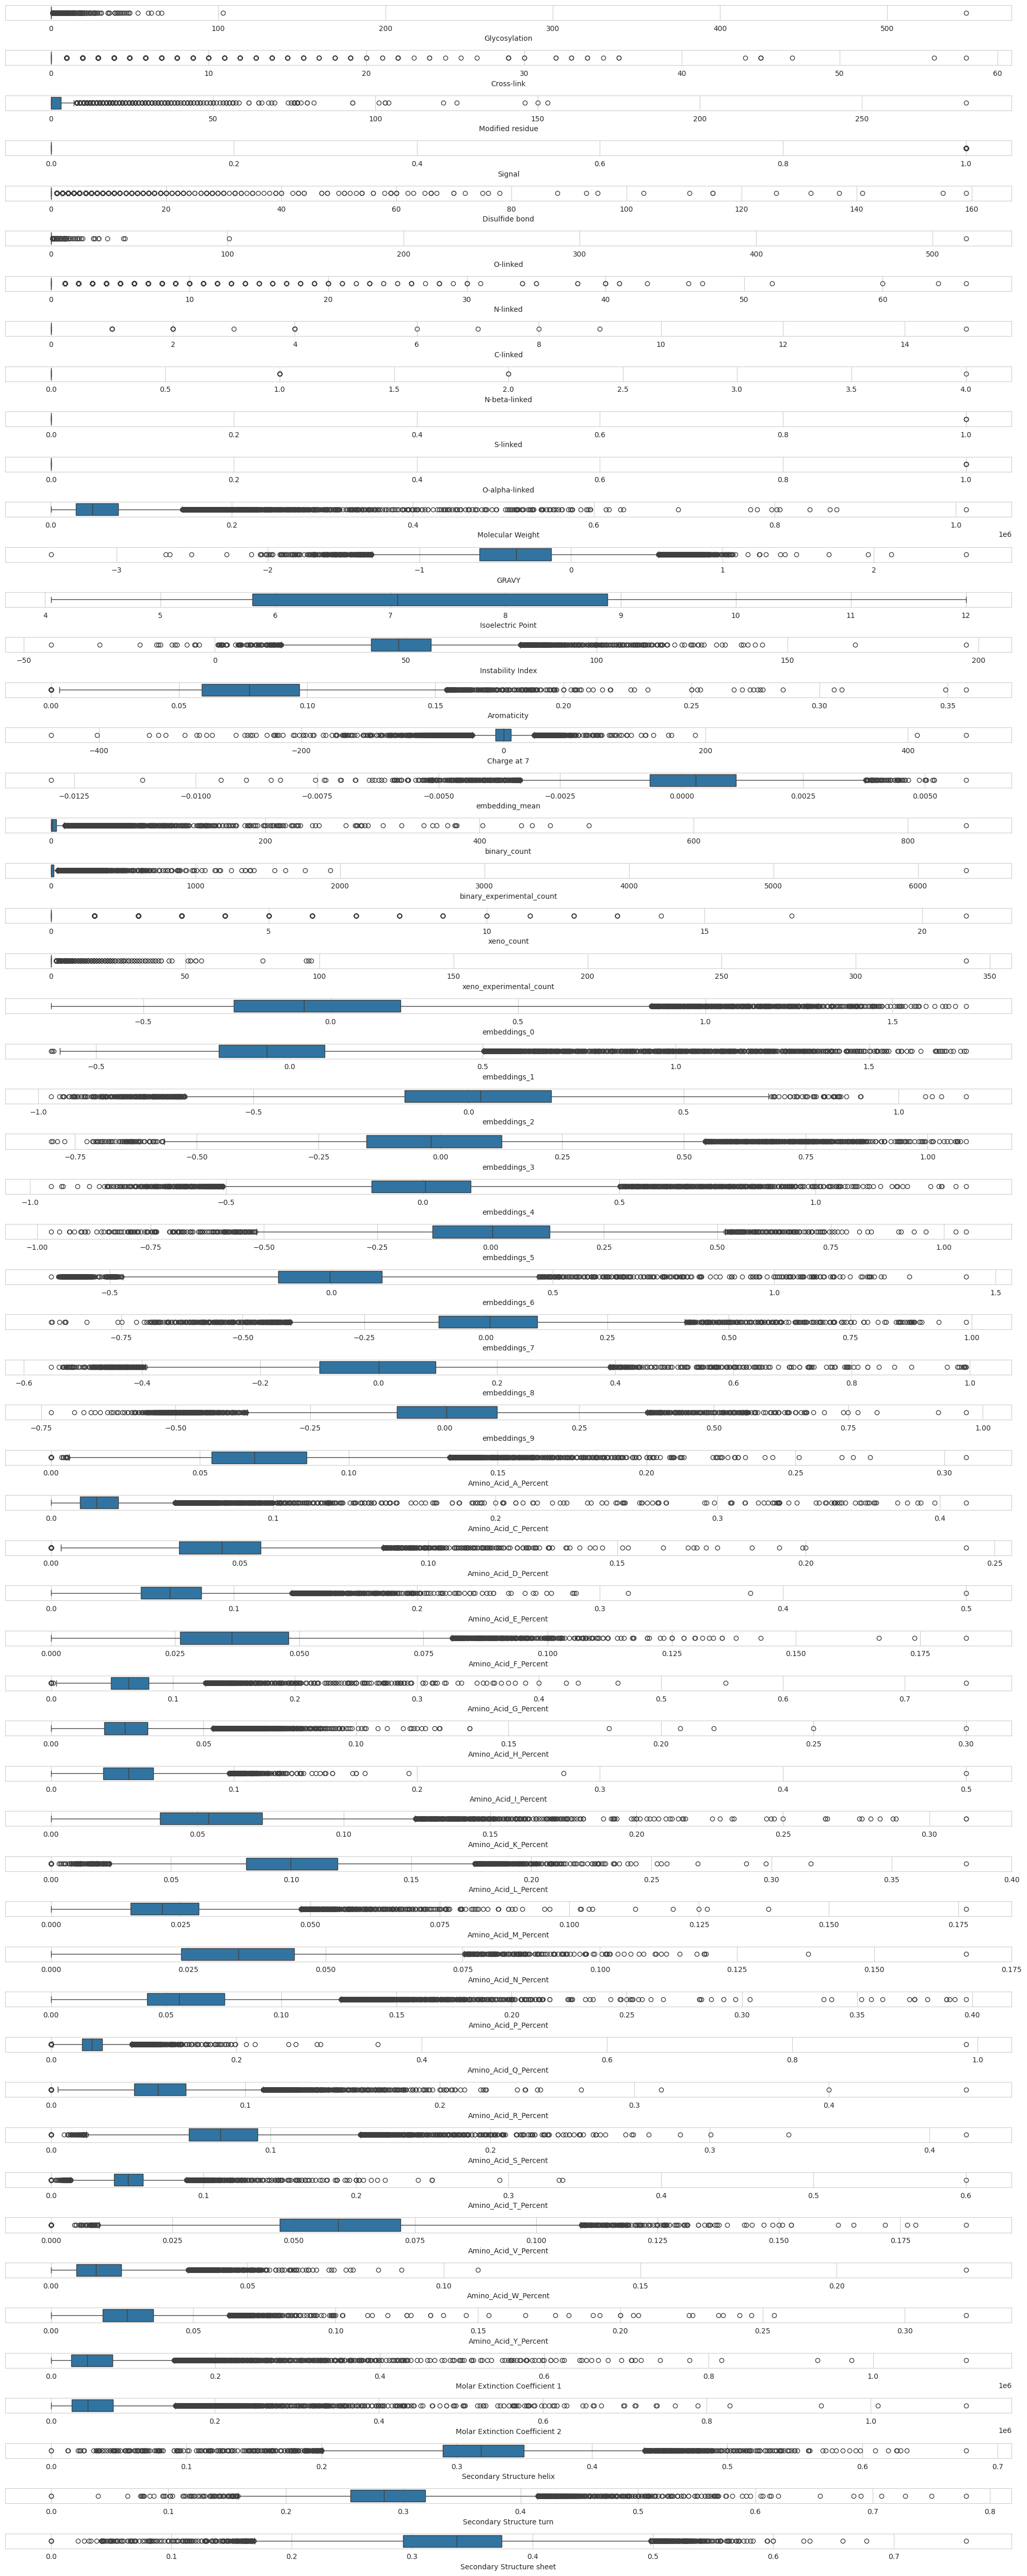

In [ ]:
fig,ax = plt.subplots(figsize = (20,50), nrows = 57 )
for i,values in enumerate(okk):
  sns.boxplot(data[values], orient = 'h',ax = ax[i])
plt.tight_layout()
plt.show()

In [ ]:
#scaling of data on same scale for further analysis(Z-score normalization)
std_scale = StandardScaler()
data[okk] = std_scale.fit_transform(data[okk])
data

Glycosylation  Cross-link  Modified residue    Signal  \
A0A087X1C5       0.024658   -0.174899         -0.392779 -0.463341   
A0A0B4J2F0      -0.184643   -0.174899         -0.392779 -0.463341   
A0A0B4J2F2      -0.184643   -0.174899         -0.392779 -0.463341   
A0A0C5B5G6      -0.184643   -0.174899         -0.392779 -0.463341   
A0A0K2S4Q6       0.024658   -0.174899         -0.392779  2.158238   
...                   ...         ...               ...       ...   
Q9UI54          -0.184643   -0.174899         -0.392779 -0.463341   
Q9UI72          -0.184643   -0.174899         -0.392779 -0.463341   
Q9Y3F1          -0.184643   -0.174899         -0.392779 -0.463341   
Q9Y6C7          -0.184643   -0.174899         -0.392779 -0.463341   
Q9Y6Z2          -0.184643   -0.174899         -0.392779 -0.463341   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5       -0.187866 -0.024352  0.083987 -0.023509      -0.019792   
A0A0B4J2F0       -0.187866 -0.024352 -0.306444 -0.023509      -0.019792   
A0A0B4J2F2       -0.187866 -0.024352 -0.306444 -0.023509      -0.019792   
A0A0C5B5G6       -0.187866 -0.024352 -0.306444 -0.023509      -0.019792   
A0A0K2S4Q6        0.021682 -0.024352  0.083987 -0.023509      -0.019792   
...                    ...       ...       ...       ...            ...   
Q9UI54           -0.187866 -0.024352 -0.306444 -0.023509      -0.019792   
Q9UI72           -0.187866 -0.024352 -0.306444 -0.023509      -0.019792   
Q9Y3F1           -0.187866 -0.024352 -0.306444 -0.023509      -0.019792   
Q9Y6C7           -0.187866 -0.024352 -0.306444 -0.023509      -0.019792   
Q9Y6Z2           -0.187866 -0.024352 -0.306444 -0.023509      -0.019792   

            S-linked  ...  Amino_Acid_S_Percent  Amino_Acid_T_Percent  \
A0A087X1C5 -0.012118  ...             -1.172662             -0.179218   
A0A0B4J2F0 -0.012118  ...             -1.598492             -0.804703   
A0A0B4J2F2 -0.012118  ...              0.197520              0.028378   
A0A0C5B5G6 -0.012118  ...             -2.969133             -2.817983   
A0A0K2S4Q6 -0.012118  ...              0.713185              1.779507   
...              ...  ...                   ...                   ...   
Q9UI54     -0.012118  ...              1.068027              3.112041   
Q9UI72     -0.012118  ...             -1.896457             -0.454567   
Q9Y3F1     -0.012118  ...              2.317624              3.006148   
Q9Y6C7     -0.012118  ...              0.180424              0.651712   
Q9Y6Z2     -0.012118  ...              0.926372              0.996653   

            Amino_Acid_V_Percent  Amino_Acid_W_Percent  Amino_Acid_Y_Percent  \
A0A087X1C5              1.300480              0.047543             -1.071705   
A0A0B4J2F0              0.721269             -1.394428              0.603623   
A0A0B4J2F2             -0.320350             -0.581494             -0.492042   
A0A0C5B5G6             -3.054601              5.236067              6.408541   
A0A0K2S4Q6              1.003050              1.244575             -0.527264   
...                          ...                   ...                   ...   
Q9UI54                 -0.274188             -1.394428              0.559184   
Q9UI72                 -2.315844              1.680584              1.028697   
Q9Y3F1                 -2.144347              2.394426              1.694773   
Q9Y6C7                 -1.427763              3.119951             -0.436452   
Q9Y6Z2                 -0.371746              0.466763              0.474982   

            Molar Extinction Coefficient 1  Molar Extinction Coefficient 2  \
A0A087X1C5                       -0.198160                       -0.200392   
A0A0B4J2F0                       -0.950950                       -0.952900   
A0A0B4J2F2                       -0.039001                       -0.032601   
A0A0C5B5G6                       -0.857825                       -0.860845   
A0A0K2S4Q6                       -0.434868            

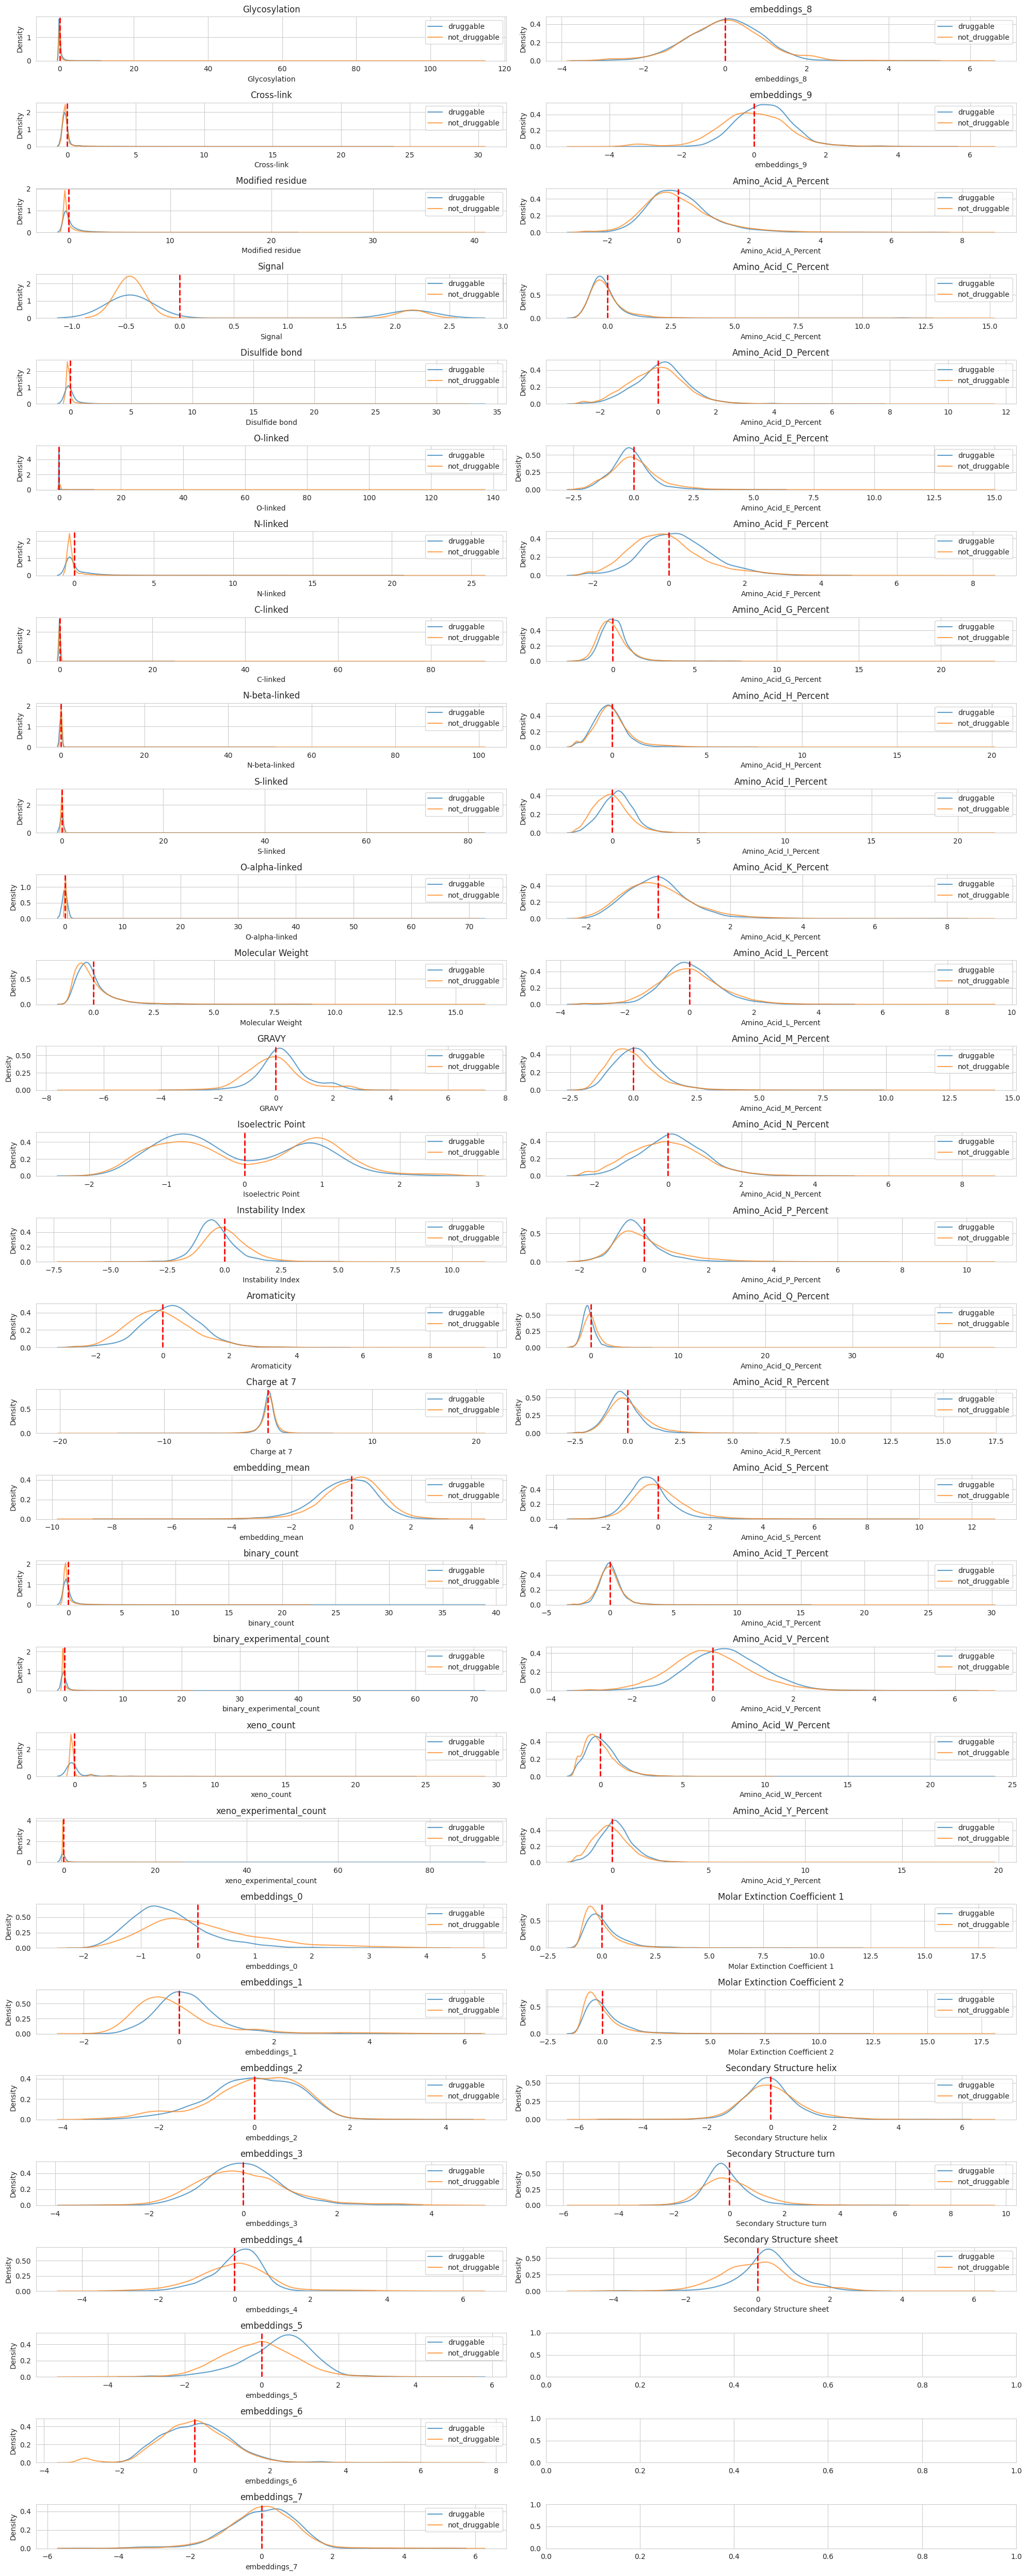

In [ ]:
fig,ax = plt.subplots(figsize = (20,50),nrows = 30,ncols = 2)
for i,values in enumerate(okk):
  if i <30:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label = 'druggable')
    sns.kdeplot(data = data[data['is_druggable'] == 0], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label ='not_druggable')
    ax[i][0].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i][0].set_title(values)
    ax[i][0].legend()
  else:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i-30][1],alpha = 0.7,common_norm = True,label = 'druggable')
    sns.kdeplot(data=data[data['is_druggable'] == 0], x=values, ax=ax[i-30][1],alpha = 0.7,common_norm = True,label ='not_druggable')
    ax[i-30][1].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i-30][1].set_title(values)
    ax[i-30][1].legend()

plt.tight_layout()
plt.show()

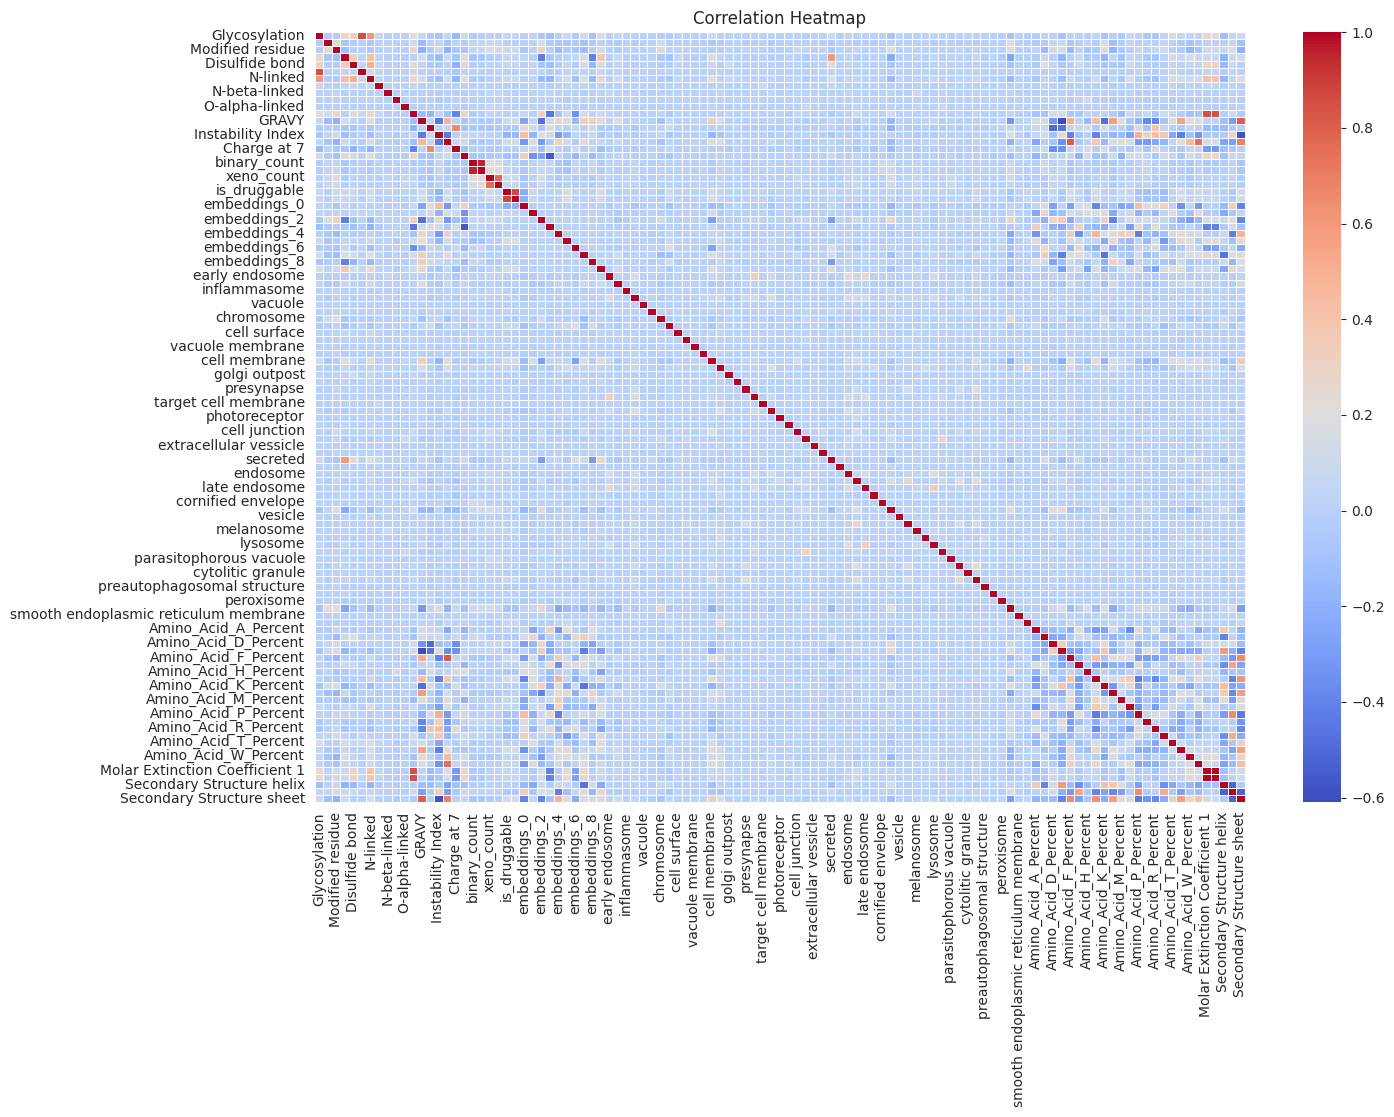

In [ ]:
okk_1 = data.copy()
plt.figure(figsize=(15, 10))
sns.heatmap(okk_1.corr(), cmap='coolwarm', annot=False, fmt=".2f",linewidth= 0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
location_data = okk_1.iloc[:,34:84]

n_components = 50
pca_list = []
feature_weight_list = []
for i in range(1,n_components):
  PCAmod = PCA(n_components = i)
  PCAmod.fit(location_data)
  pca_list.append(pd.Series({
      "n" : i,
      "model" : PCAmod,
      "var" : PCAmod.explained_variance_ratio_.sum(),
  }))
  weights = PCAmod.explained_variance_ratio_.reshape(-1, 1) / PCAmod.explained_variance_ratio_.sum()
  overall_contributions = np.abs(PCAmod.components_) * weights
  abs_feature_values = overall_contributions.sum(axis=0)
  feature_weight_list.append(pd.DataFrame({
      'n': i,
      'features': location_data.columns,
      'values': abs_feature_values / abs_feature_values.sum(),
  }))
pca_report = pd.DataFrame(pca_list)
feature_importance_report = pd.concat(feature_weight_list).pivot(index='n', columns='features', values='values')

In [ ]:
pca_report

n                 model       var
0    1   PCA(n_components=1)  0.226165
1    2   PCA(n_components=2)  0.376399
2    3   PCA(n_components=3)  0.496172
3    4   PCA(n_components=4)  0.574321
4    5   PCA(n_components=5)  0.639989
5    6   PCA(n_components=6)  0.695296
6    7   PCA(n_components=7)  0.740939
7    8   PCA(n_components=8)  0.781687
8    9   PCA(n_components=9)  0.817656
9   10  PCA(n_components=10)  0.844329
10  11  PCA(n_components=11)  0.866740
11  12  PCA(n_components=12)  0.884948
12  13  PCA(n_components=13)  0.899798
13  14  PCA(n_components=14)  0.911750
14  15  PCA(n_components=15)  0.923288
15  16  PCA(n_components=16)  0.933272
16  17  PCA(n_components=17)  0.940555
17  18  PCA(n_components=18)  0.946194
18  19  PCA(n_components=19)  0.950986
19  20  PCA(n_components=20)  0.955659
20  21  PCA(n_components=21)  0.960072
21  22  PCA(n_components=22)  0.964354
22  23  PCA(n_components=23)  0.968512
23  24  PCA(n_components=24)  0.972412
24  25  PCA(n_components=25)  0.975945
25  26  PCA(n_components=26)  0.979316
26  27  PCA(n_components=27)  0.982415
27  28  PCA(n_components=28)  0.985072
28  29  PCA(n_components=29)  0.987338
29  30  PCA(n_components=30)  0.989434
30  31  PCA(n_components=31)  0.991085
31  32  PCA(n_components=32)  0.992541
32  33  PCA(n_components=33)  0.993683
33  34  PCA(n_components=34)  0.994726
34  35  PCA(n_components=35)  0.995605
35  36  PCA(n_components=36)  0.996263
36  37  PCA(n_components=37)  0.996792
37  38  PCA(n_components=38)  0.997273
38  39  PCA(n_components=39)  0.997713
39  40  PCA(n_components=40)  0.998152
40  41  PCA(n_components=41)  0.998548
41  42  PCA(n_components=42)  0.998943
42  43  PCA(n_components=43)  0.999208
43  44  PCA(n_components=44)  0.999428
44  45  PCA(n_components=45)  0.999648
45  46  PCA(n_components=46)  0.999779
46  47  PCA(n_components=47)  0.999868
47  48  PCA(n_components=48)  0.999912
48  49  PCA(n_components=49)  0.999956

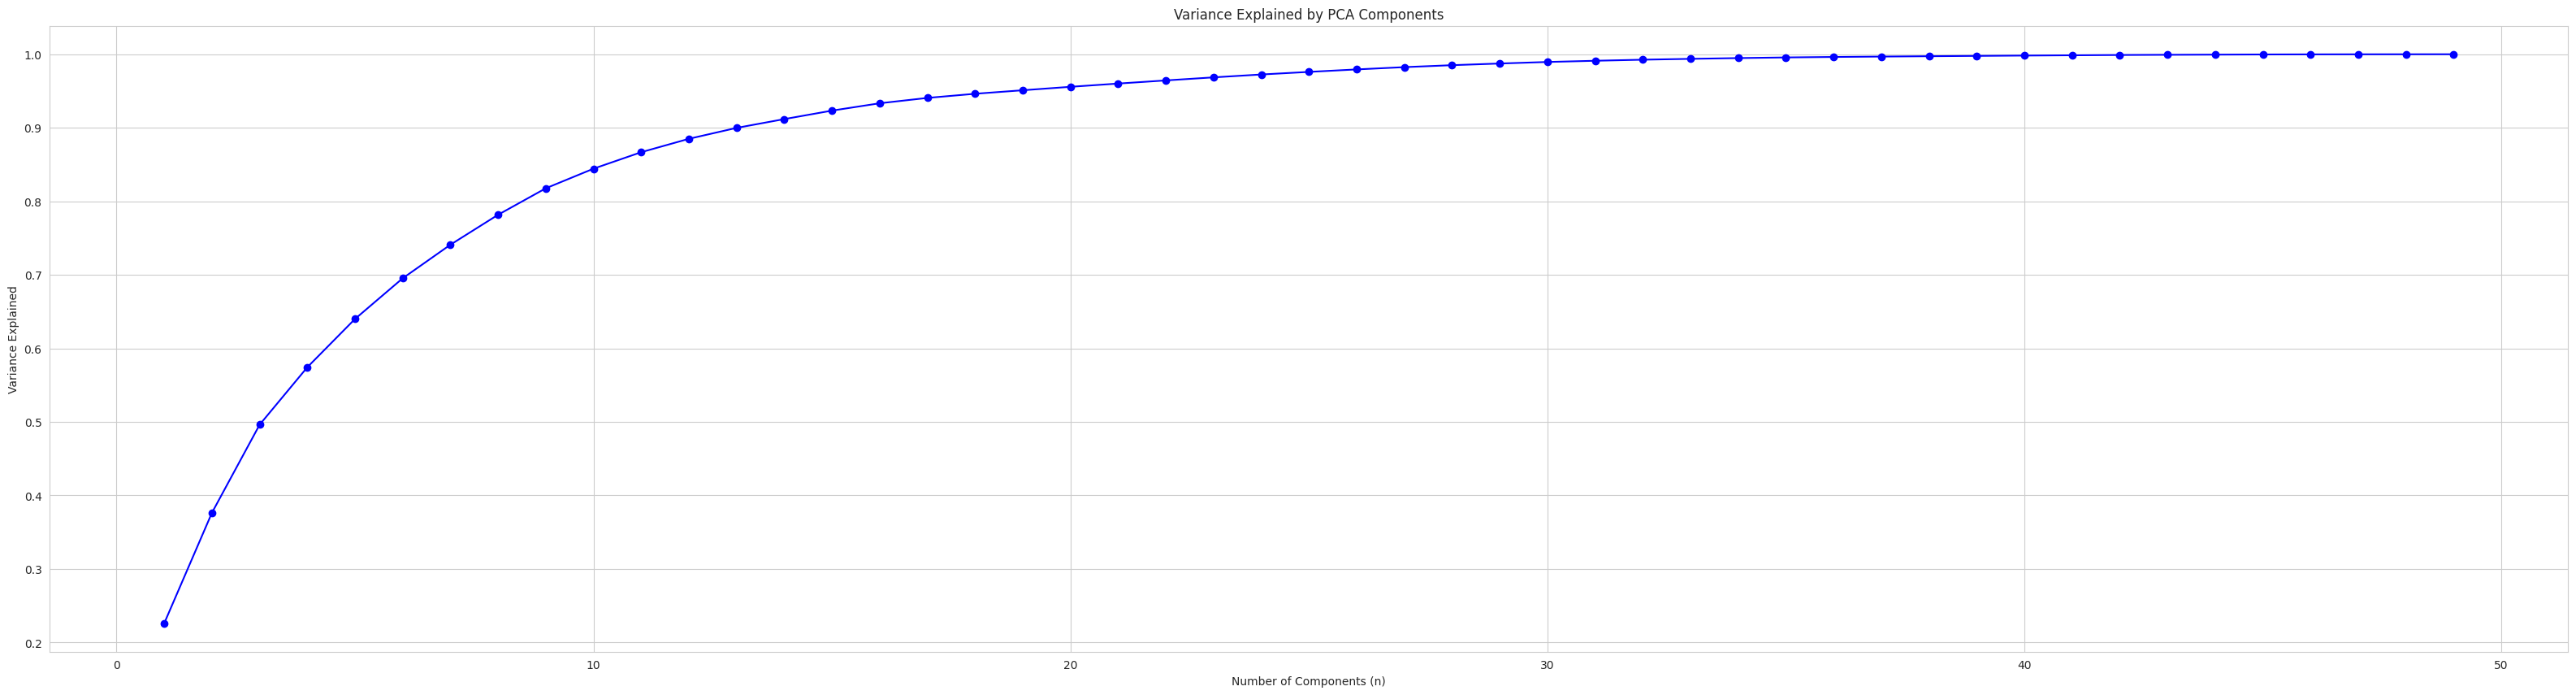

In [ ]:
fig,ax = plt.subplots(figsize = (40,10))
plt.plot(pca_report['n'], pca_report['var'], marker = 'o', linestyle = "-", color = 'b')
plt.title('Variance Explained by PCA Components')
# plt.axvline(x=150, color='r', linestyle='--', linewidth=2, label='Threshold at x=50')
plt.xlabel('Number of Components (n)')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

[Text(0.5, 0, 'Number of components'),
 Text(0, 0.5, 'Relative Importance'),
 Text(0.5, 1.0, 'Feature Importance Vs Dimensions')]

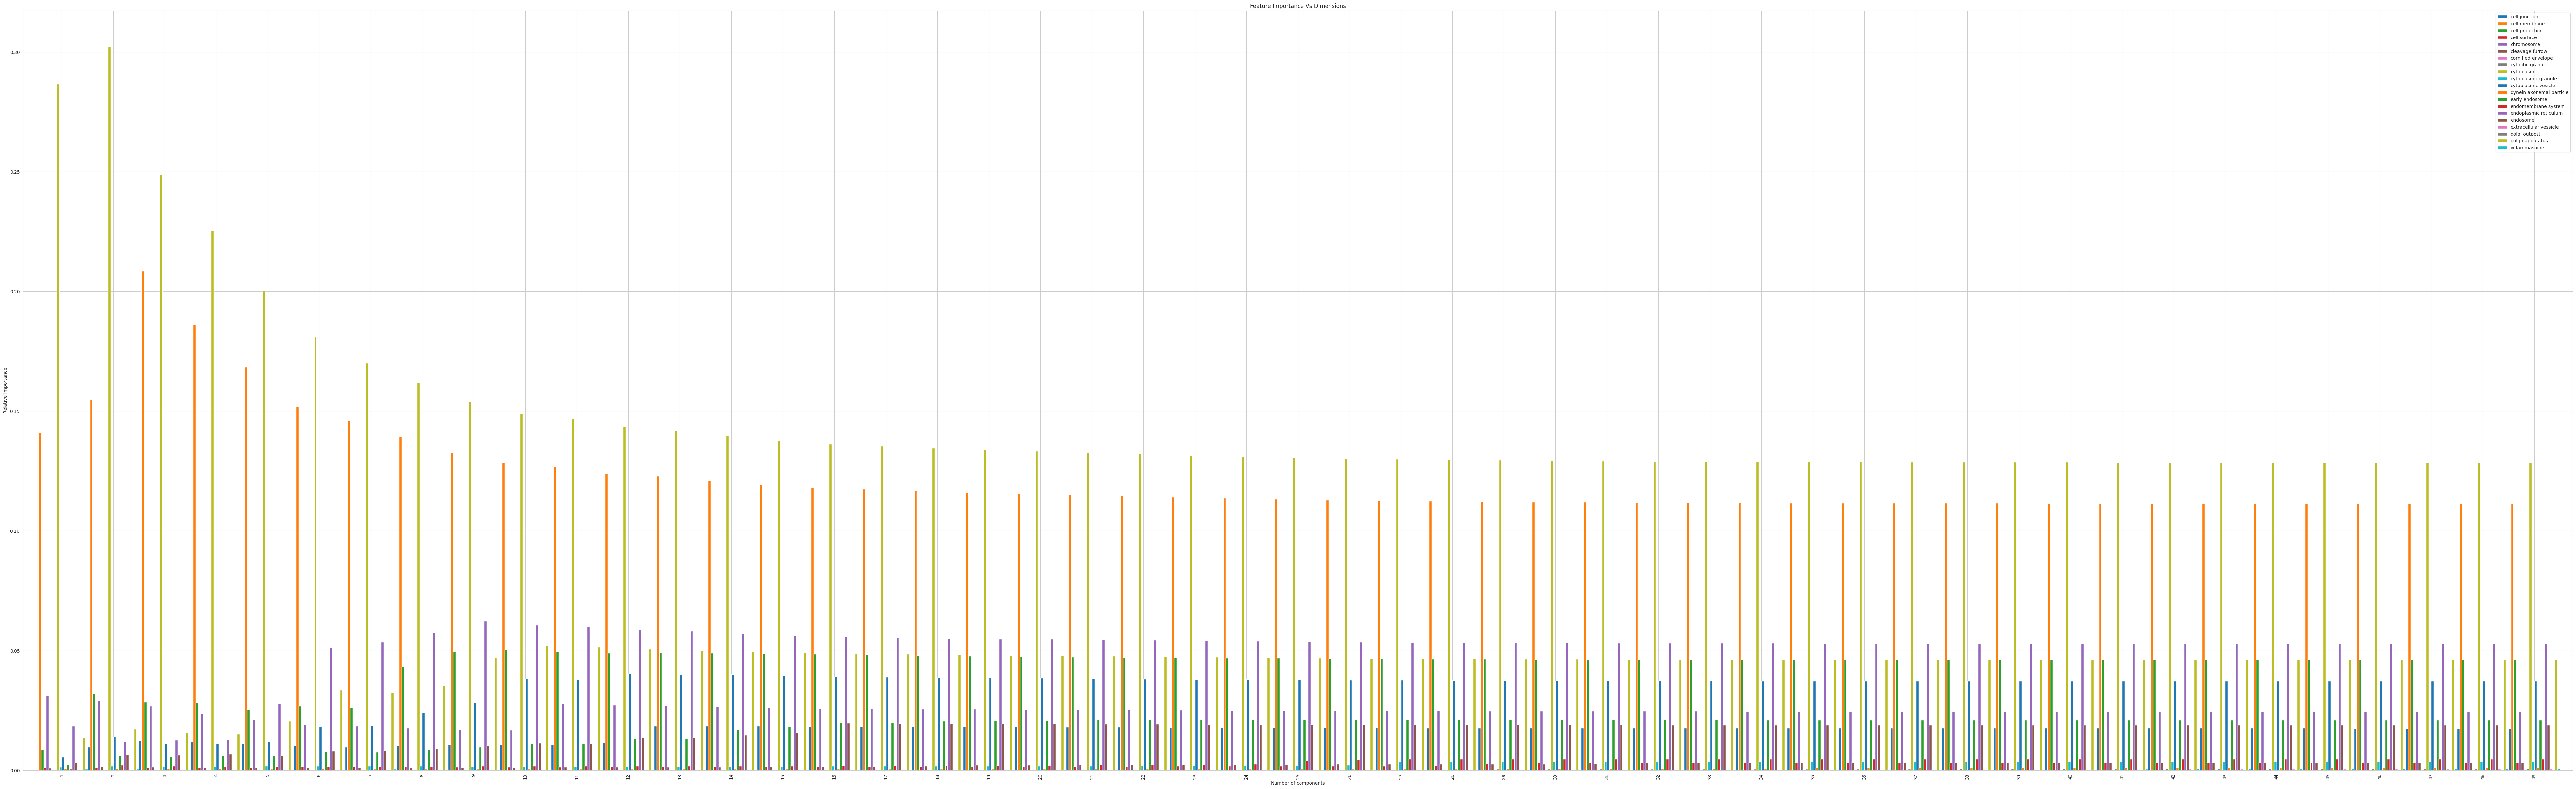

In [ ]:
ax = feature_importance_report.iloc[:,:20].plot(kind = 'bar' , figsize = (100,30), width=1)
ax.legend(loc = 'upper right')
ax.set(xlabel = 'Number of components' ,  ylabel = 'Relative Importance' , title = 'Feature Importance Vs Dimensions')

<Figure size 2000x1200 with 0 Axes>

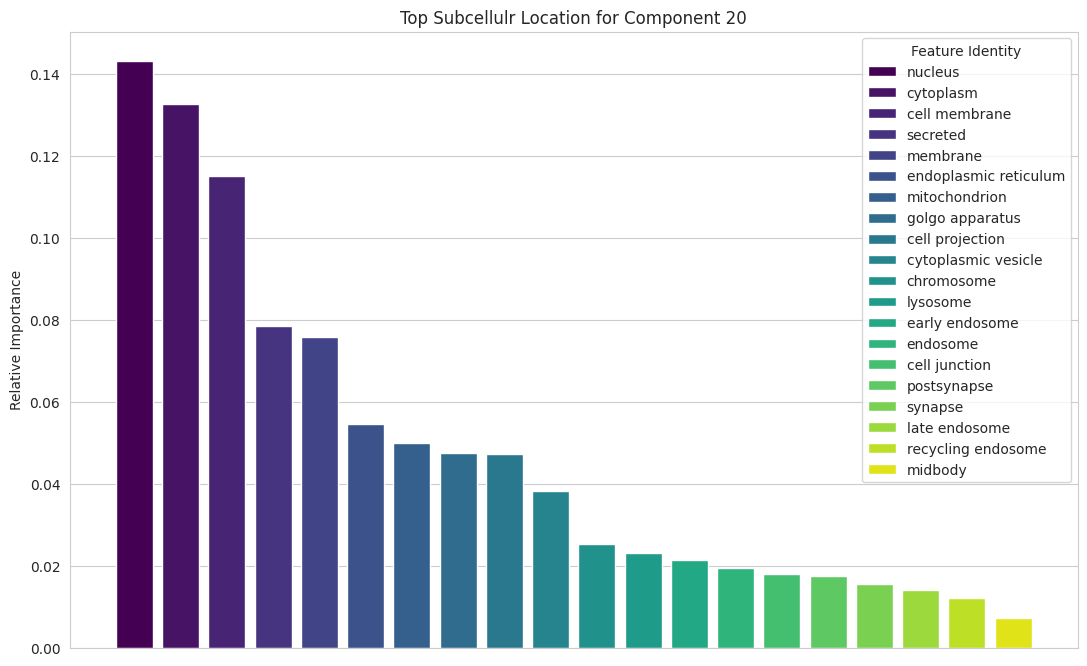

In [ ]:
plt.figure(figsize= (20,12))
n_top_features = 20
top_features = feature_importance_report.iloc[20].nlargest(n_top_features)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (feature, importance) in enumerate(top_features.items()):
    ax.bar(idx, importance, label=feature, color=plt.cm.viridis(idx / len(top_features)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Feature Identity')

ax.set(ylabel='Relative Importance', title='Top Subcellulr Location for Component 20')
plt.show()

In [ ]:
okk_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20431 entries, A0A087X1C5 to Q9Y6Z2
Columns: 109 entries, Glycosylation to Secondary Structure sheet
dtypes: float64(57), int64(52)
memory usage: 17.7+ MB


In [ ]:
#PCA Analysis for reduction and selection of relevant ones

n_components = 63
pca_list = []
feature_weight_list = []
for i in range(1,n_components):
  PCAmod = PCA(n_components = i)
  PCAmod.fit(okk_1)
  pca_list.append(pd.Series({
      "n" : i,
      "model" : PCAmod,
      "var" : PCAmod.explained_variance_ratio_.sum(),
  }))
  weights = PCAmod.explained_variance_ratio_.reshape(-1, 1) / PCAmod.explained_variance_ratio_.sum()
  overall_contributions = np.abs(PCAmod.components_) * weights
  abs_feature_values = overall_contributions.sum(axis=0)
  feature_weight_list.append(pd.DataFrame({
      'n': i,
      'features': okk_1.columns,
      'values': abs_feature_values / abs_feature_values.sum(),
  }))
pca_report = pd.DataFrame(pca_list)
feature_importance_report = pd.concat(feature_weight_list).pivot(index='n', columns='features', values='values')

In [ ]:
pca_report

n                 model       var
0    1   PCA(n_components=1)  0.119935
1    2   PCA(n_components=2)  0.200528
2    3   PCA(n_components=3)  0.279576
3    4   PCA(n_components=4)  0.332024
4    5   PCA(n_components=5)  0.377234
..  ..                   ...       ...
57  58  PCA(n_components=58)  0.995724
58  59  PCA(n_components=59)  0.996343
59  60  PCA(n_components=60)  0.996844
60  61  PCA(n_components=61)  0.997239
61  62  PCA(n_components=62)  0.997580

[62 rows x 3 columns]

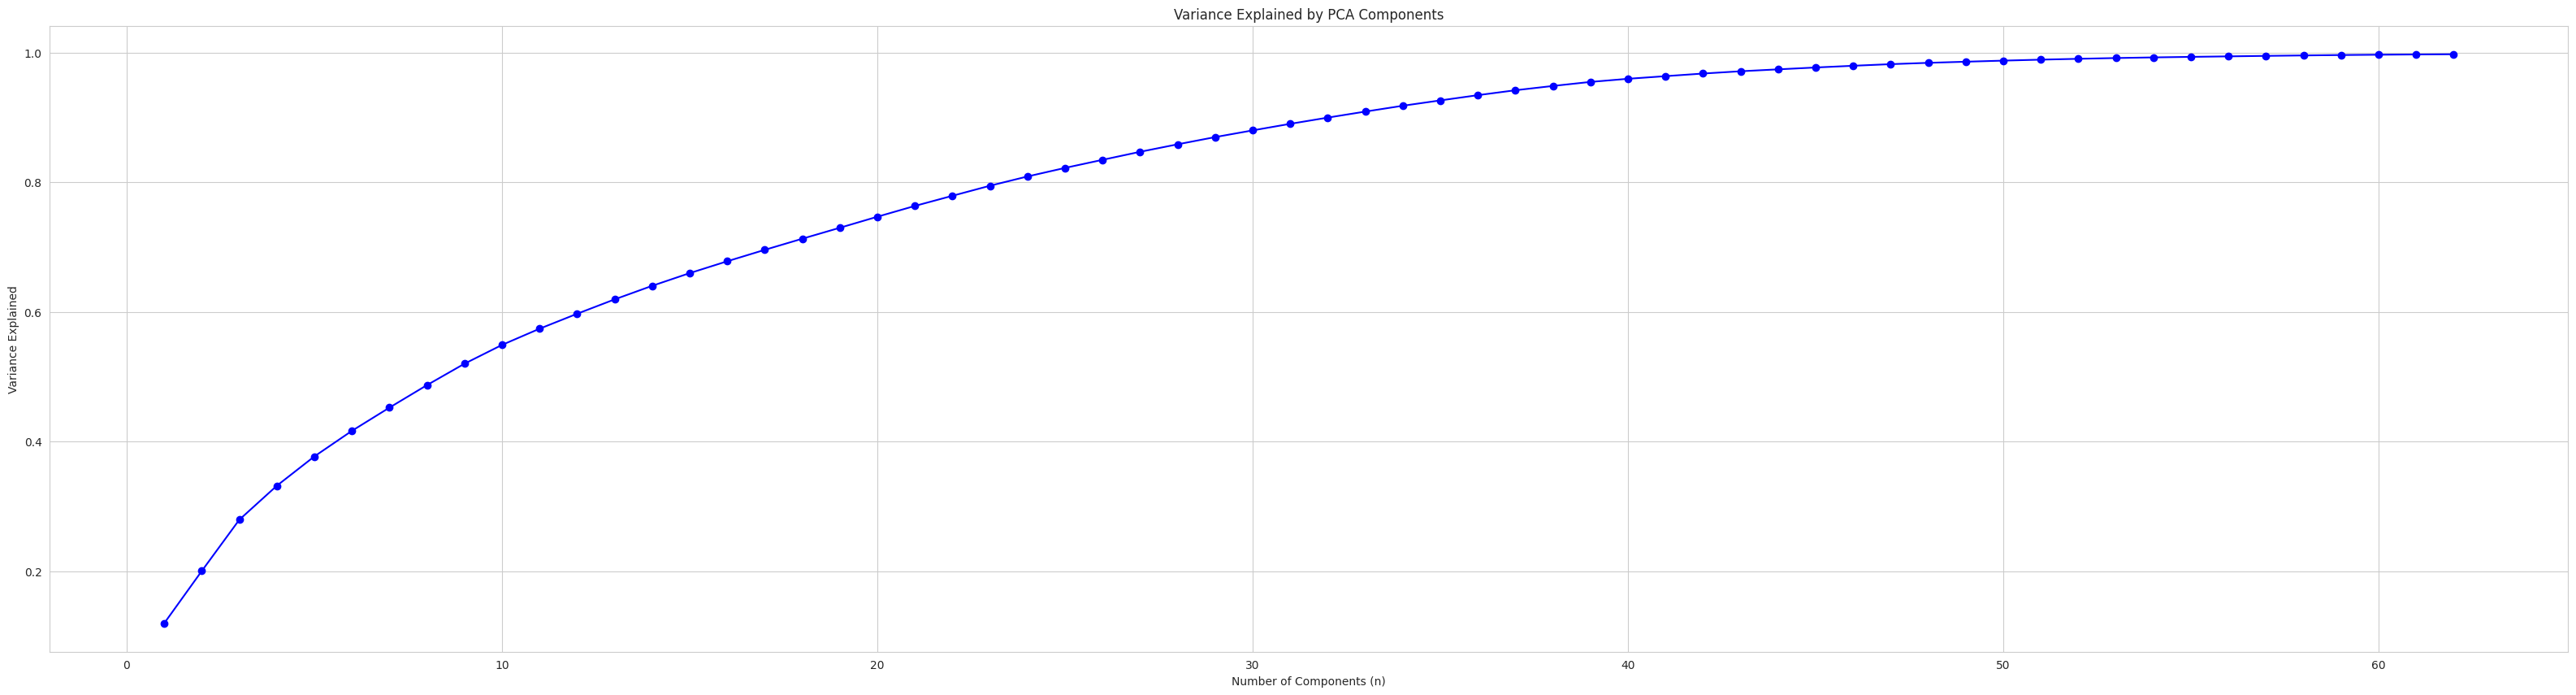

In [ ]:
fig,ax = plt.subplots(figsize = (40,10))
plt.plot(pca_report['n'], pca_report['var'], marker = 'o', linestyle = "-", color = 'b')
plt.title('Variance Explained by PCA Components')
# plt.axvline(x=150, color='r', linestyle='--', linewidth=2, label='Threshold at x=50')
plt.xlabel('Number of Components (n)')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

[Text(0.5, 0, 'Number of components'),
 Text(0, 0.5, 'Relative Importance'),
 Text(0.5, 1.0, 'Feature Importance Vs Dimensions')]

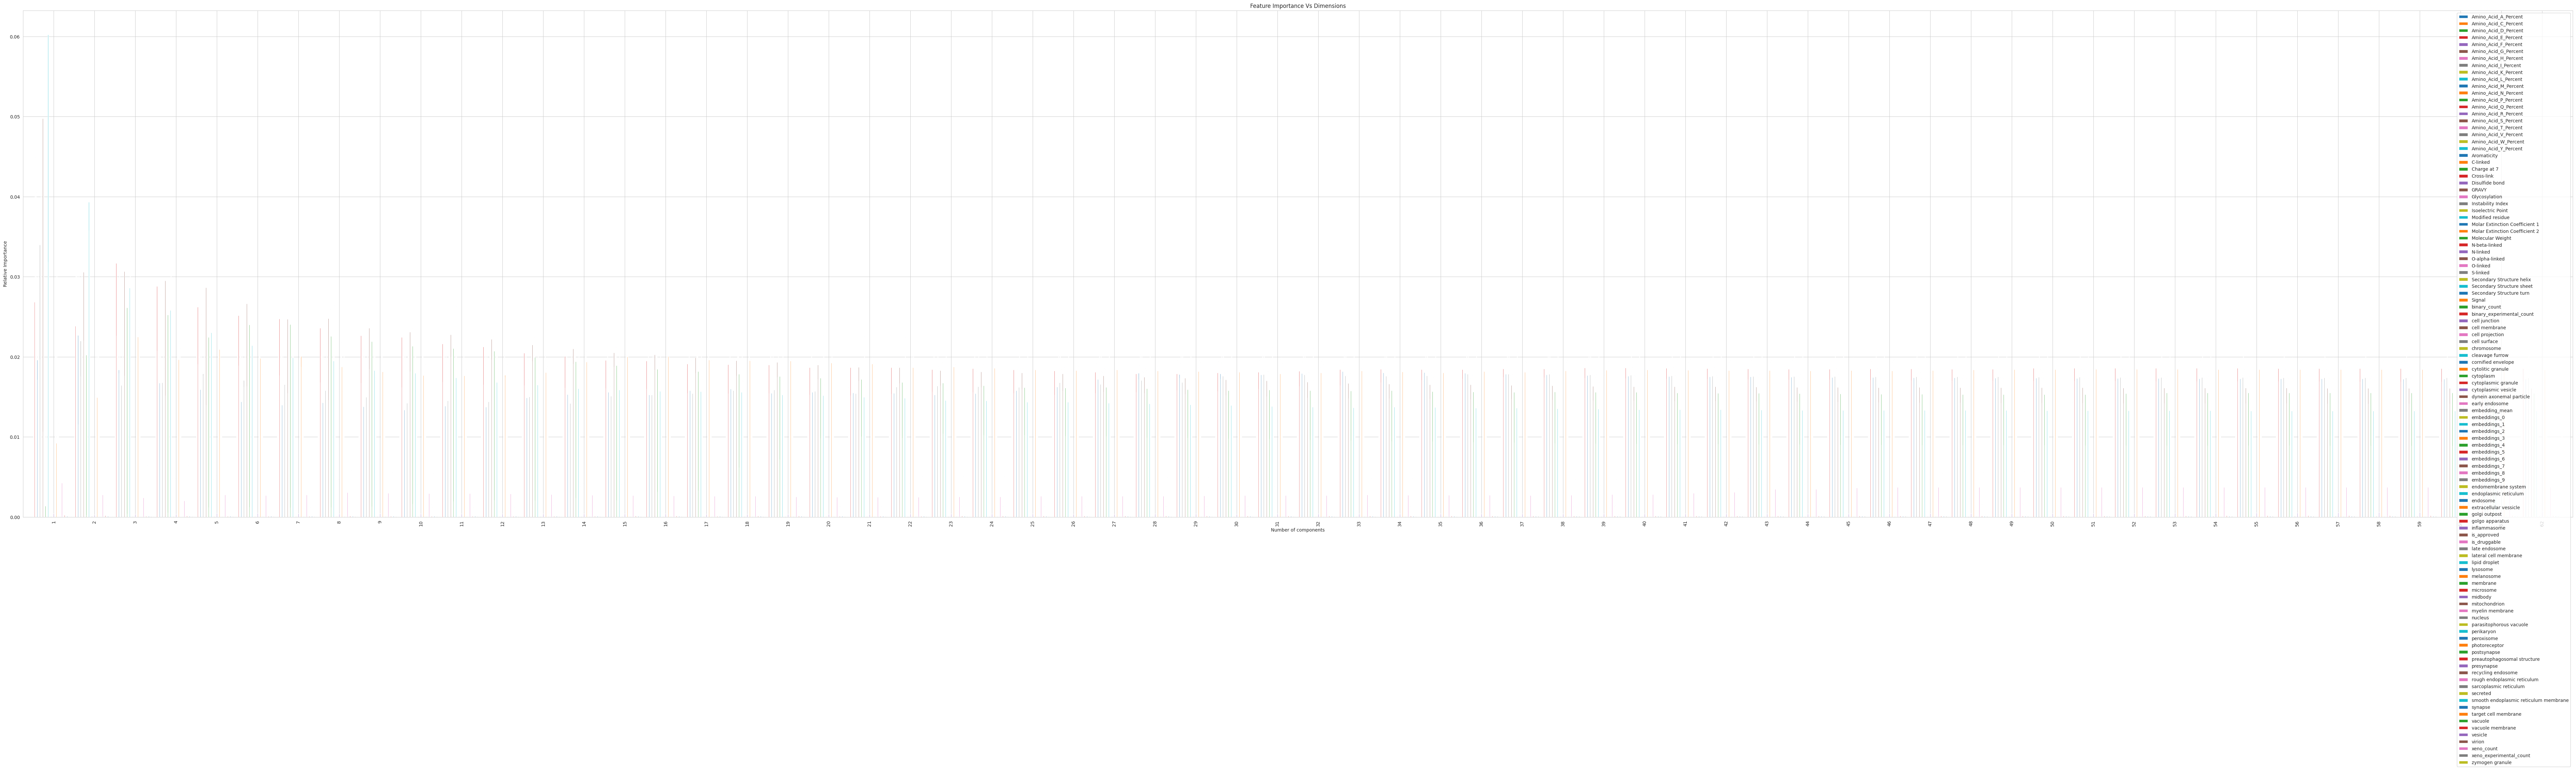

In [ ]:
ax = feature_importance_report.plot(kind = 'bar' , figsize = (100,20), width=1)
ax.legend(loc = 'upper right')
ax.set(xlabel = 'Number of components' ,  ylabel = 'Relative Importance' , title = 'Feature Importance Vs Dimensions')

<Figure size 2000x1200 with 0 Axes>

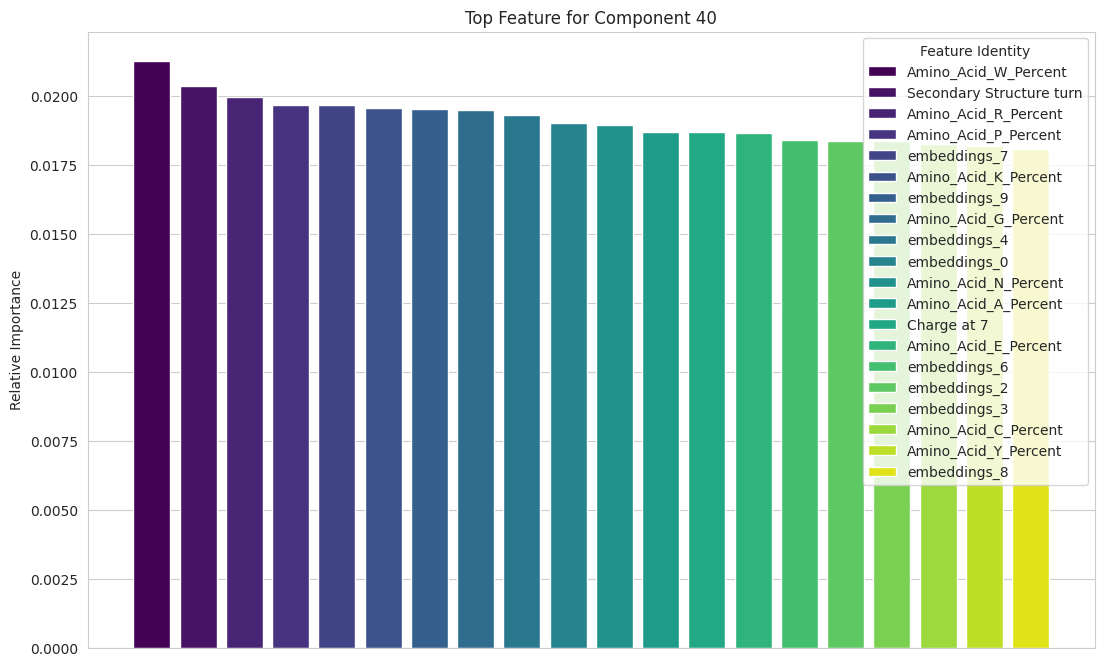

In [ ]:
plt.figure(figsize= (20,12))
n_top_features = 20
top_features = feature_importance_report.iloc[39].nlargest(n_top_features)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (feature, importance) in enumerate(top_features.items()):
    ax.bar(idx, importance, label=feature, color=plt.cm.viridis(idx / len(top_features)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Feature Identity')

ax.set(ylabel='Relative Importance', title='Top Feature for Component 40')
plt.show()

<Figure size 2000x1200 with 0 Axes>

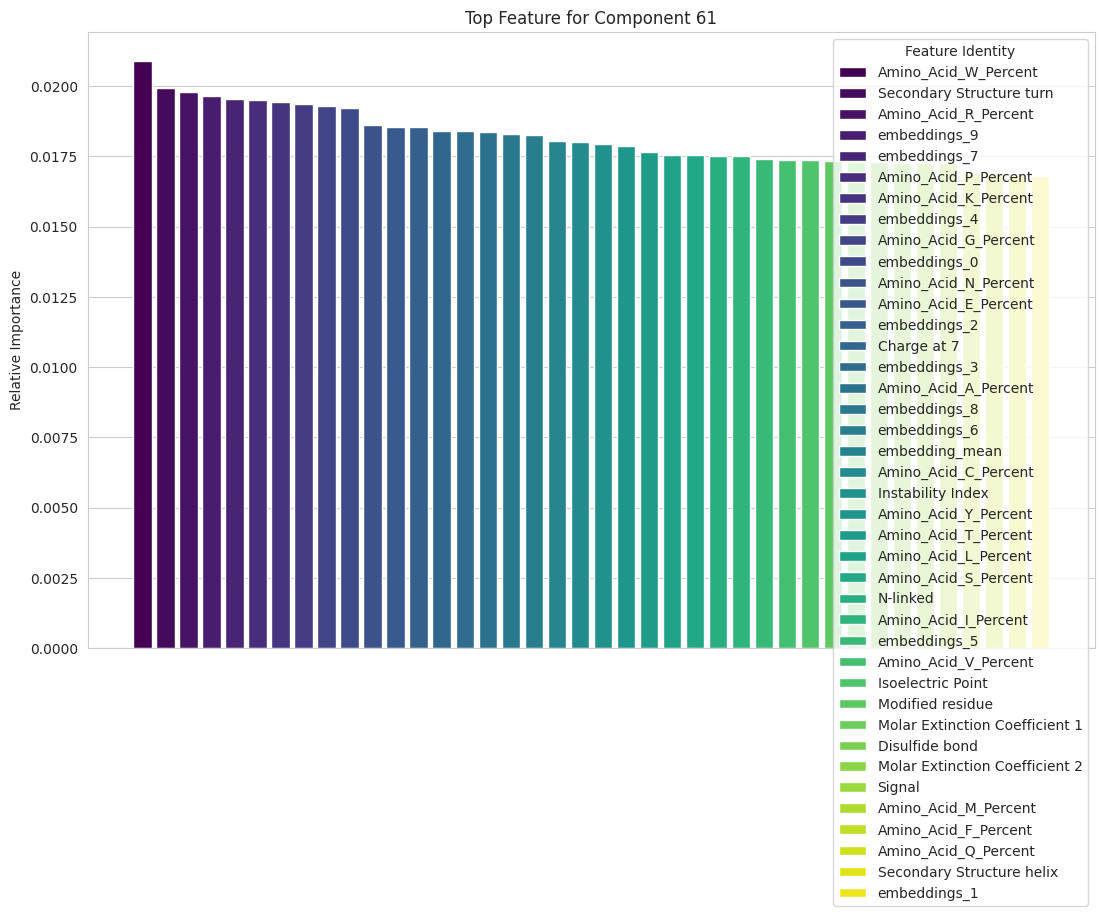

In [ ]:
plt.figure(figsize= (20,12))
n_top_features = 40
top_features = feature_importance_report.iloc[61].nlargest(n_top_features)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (feature, importance) in enumerate(top_features.items()):
    ax.bar(idx, importance, label=feature, color=plt.cm.viridis(idx / len(top_features)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Feature Identity')

ax.set(ylabel='Relative Importance', title='Top Feature for Component 61')
plt.show()

zymogen granule     0.000000
vacuole             0.000000
cell surface        0.000000
myelin membrane     0.000000
vacuole membrane    0.000000
                      ...   
embeddings_5        0.032483
Disulfide bond      0.036854
microsome           0.037367
embeddings_0        0.045120
chromosome          0.143395
Length: 107, dtype: float32


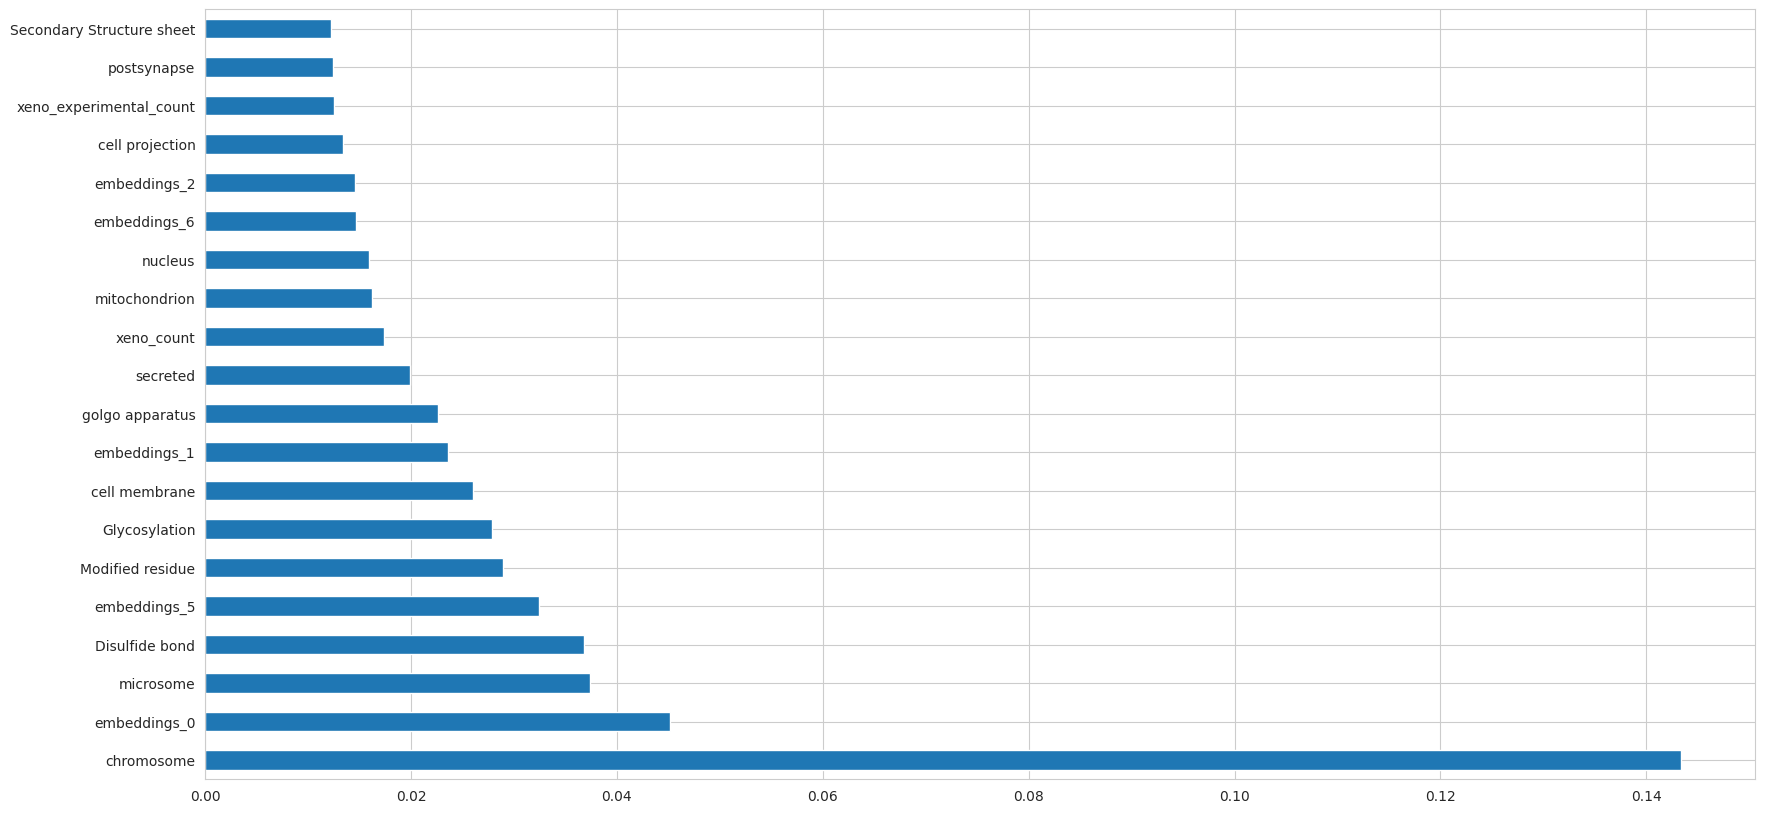

In [ ]:
#lets see each feature importance using XGB Classifier
okk_1 = okk_1.drop(columns = ['is_approved'])
import xgboost

x_sample = okk_1.drop(columns = ['is_druggable'])
y_sample = okk_1['is_druggable']

model = xgboost.XGBClassifier()
model.fit(x_sample,y_sample)

feat_imp = pd.Series(model.feature_importances_, index=x_sample.columns)
print(feat_imp.sort_values())
feat_imp.nlargest(20).plot(kind='barh',figsize=(20,10))

plt.show()

In [ ]:
druggable_indices = (y_sample == 1)  # Assuming 1 represents druggable
non_druggable_indices = (y_sample == 0)  # Assuming 0 represents non-druggable

druggable_X = x_sample[druggable_indices]
druggable_y = y_sample[druggable_indices]

non_druggable_X = x_sample[non_druggable_indices]
non_druggable_y = y_sample[non_druggable_indices]

In [ ]:
class_size = 1000
druggable_X_remaining, druggable_X_test, druggable_y_remaining, druggable_y_test = train_test_split(druggable_X, druggable_y, test_size=class_size, random_state=123)
non_druggable_X_remaining, non_druggable_X_test, non_druggable_y_remaining, non_druggable_y_test = train_test_split(non_druggable_X, non_druggable_y, test_size=class_size, random_state=123)

In [ ]:
X_test = pd.concat((druggable_X_test, non_druggable_X_test))
y_test = pd.concat((druggable_y_test, non_druggable_y_test))

X_train = pd.concat((druggable_X_remaining, non_druggable_X_remaining))
y_train = pd.concat((druggable_y_remaining, non_druggable_y_remaining))

In [ ]:
#model building
sc = StandardScaler()
oversample = SMOTE()
X_train,y_train = oversample.fit_resample(X_train,y_train)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#using xgboost boosting algorithms
model_1 = xgboost.XGBClassifier()
model_1.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.model_selection import cross_validate

def test_results(model, k):
  results = {}
  scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
  okk = cross_validate(model, X_test, y_test, cv=k, scoring=scoring)

  for metric in scoring:
    mean_score = np.mean(okk['test_' + metric])
    results[metric] = mean_score


  return results

In [ ]:
y_pred = model_1.predict(X_test)
metrics_1 = test_results(model_1, 5)

In [ ]:
metrics_1

{'accuracy': 0.7766666666666666,
 'precision_weighted': 0.7707028128473626,
 'recall_weighted': 0.7766666666666666,
 'f1_weighted': 0.7708131495471007}

In [ ]:
#using logistic regression algorithm
model_2 = LogisticRegression(max_iter = 1000)
model_2.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred_2 = model_2.predict(X_test)
metrics_2= test_results(model_2, 5)
metrics_2

{'accuracy': 0.7366666666666667,
 'precision_weighted': 0.7274052602211565,
 'recall_weighted': 0.7366666666666667,
 'f1_weighted': 0.7288626744463217}

In [ ]:
#using SVM algorithm using various kernels
model_3 = svm.SVC(kernel = 'linear',probability = True)
model_4 = svm.SVC(kernel = 'poly',probability = True)
model_5 = svm.SVC(kernel = 'rbf',probability = True)

model_3.fit(X_train,y_train)
model_4.fit(X_train,y_train)
model_5.fit(X_train,y_train)

SVC(probability=True)

In [ ]:
y_pred_3 = model_3.predict(X_test)
metrics_3= test_results(model_3, 5)

y_pred_4 = model_4.predict(X_test)
metrics_4= test_results(model_4, 5)

y_pred_5 = model_3.predict(X_test)
metrics_5 = test_results(model_5, 5)


In [ ]:
#using RandomForest with estimator = 1500 which is no of trees employed
model_6 = RandomForestClassifier(n_estimators = 1500, criterion = 'entropy', random_state = 42)
model_6.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=1500, random_state=42)

In [ ]:
y_pred_6 = model_6.predict(X_test)
metrics_6= test_results(model_6, 5)

In [ ]:
#using ANN for classification

import tensorflow as tf
from tensorflow.keras import layers

model_7 = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model_7.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 50)

Epoch 1/50
943/943 [==============================] - 6s 4ms/step - loss: 0.4585 - accuracy: 0.7947 - val_loss: 0.6256 - val_accuracy: 0.7313
Epoch 2/50
943/943 [==============================] - 3s 3ms/step - loss: 0.3608 - accuracy: 0.8483 - val_loss: 0.5724 - val_accuracy: 0.7507
Epoch 3/50
943/943 [==============================] - 5s 5ms/step - loss: 0.3242 - accuracy: 0.8674 - val_loss: 0.6025 - val_accuracy: 0.7617
Epoch 4/50
943/943 [==============================] - 4s 5ms/step - loss: 0.2940 - accuracy: 0.8816 - val_loss: 0.6113 - val_accuracy: 0.7723
Epoch 5/50
943/943 [==============================] - 3s 3ms/step - loss: 0.2650 - accuracy: 0.8933 - val_loss: 0.7351 - val_accuracy: 0.7653
Epoch 6/50
943/943 [==============================] - 3s 4ms/step - loss: 0.2448 - accuracy: 0.9022 - val_loss: 0.6283 - val_accuracy: 0.7733
Epoch 7/50
943/943 [==============================] - 5s 5ms/step - loss: 0.2253 - accuracy: 0.9114 - val_loss: 0.6663 - val_accuracy: 0.7723
Epoch 

In [ ]:
y_pred_7 = model_7.predict(X_test)
y_pred_7 = (y_pred_7 >= 0.5).astype(int)
metrics_7 = {
  'accuracy' : accuracy_score(y_test,y_pred),
  'precision_weighted' : precision_score(y_test,y_pred,average = 'weighted'),
  'recall_weighted' : recall_score(y_test,y_pred,average = 'weighted'),
  'f1_weighted' : f1_score(y_test,y_pred,average = 'weighted'),
}

94/94 [==============================] - 0s 2ms/step


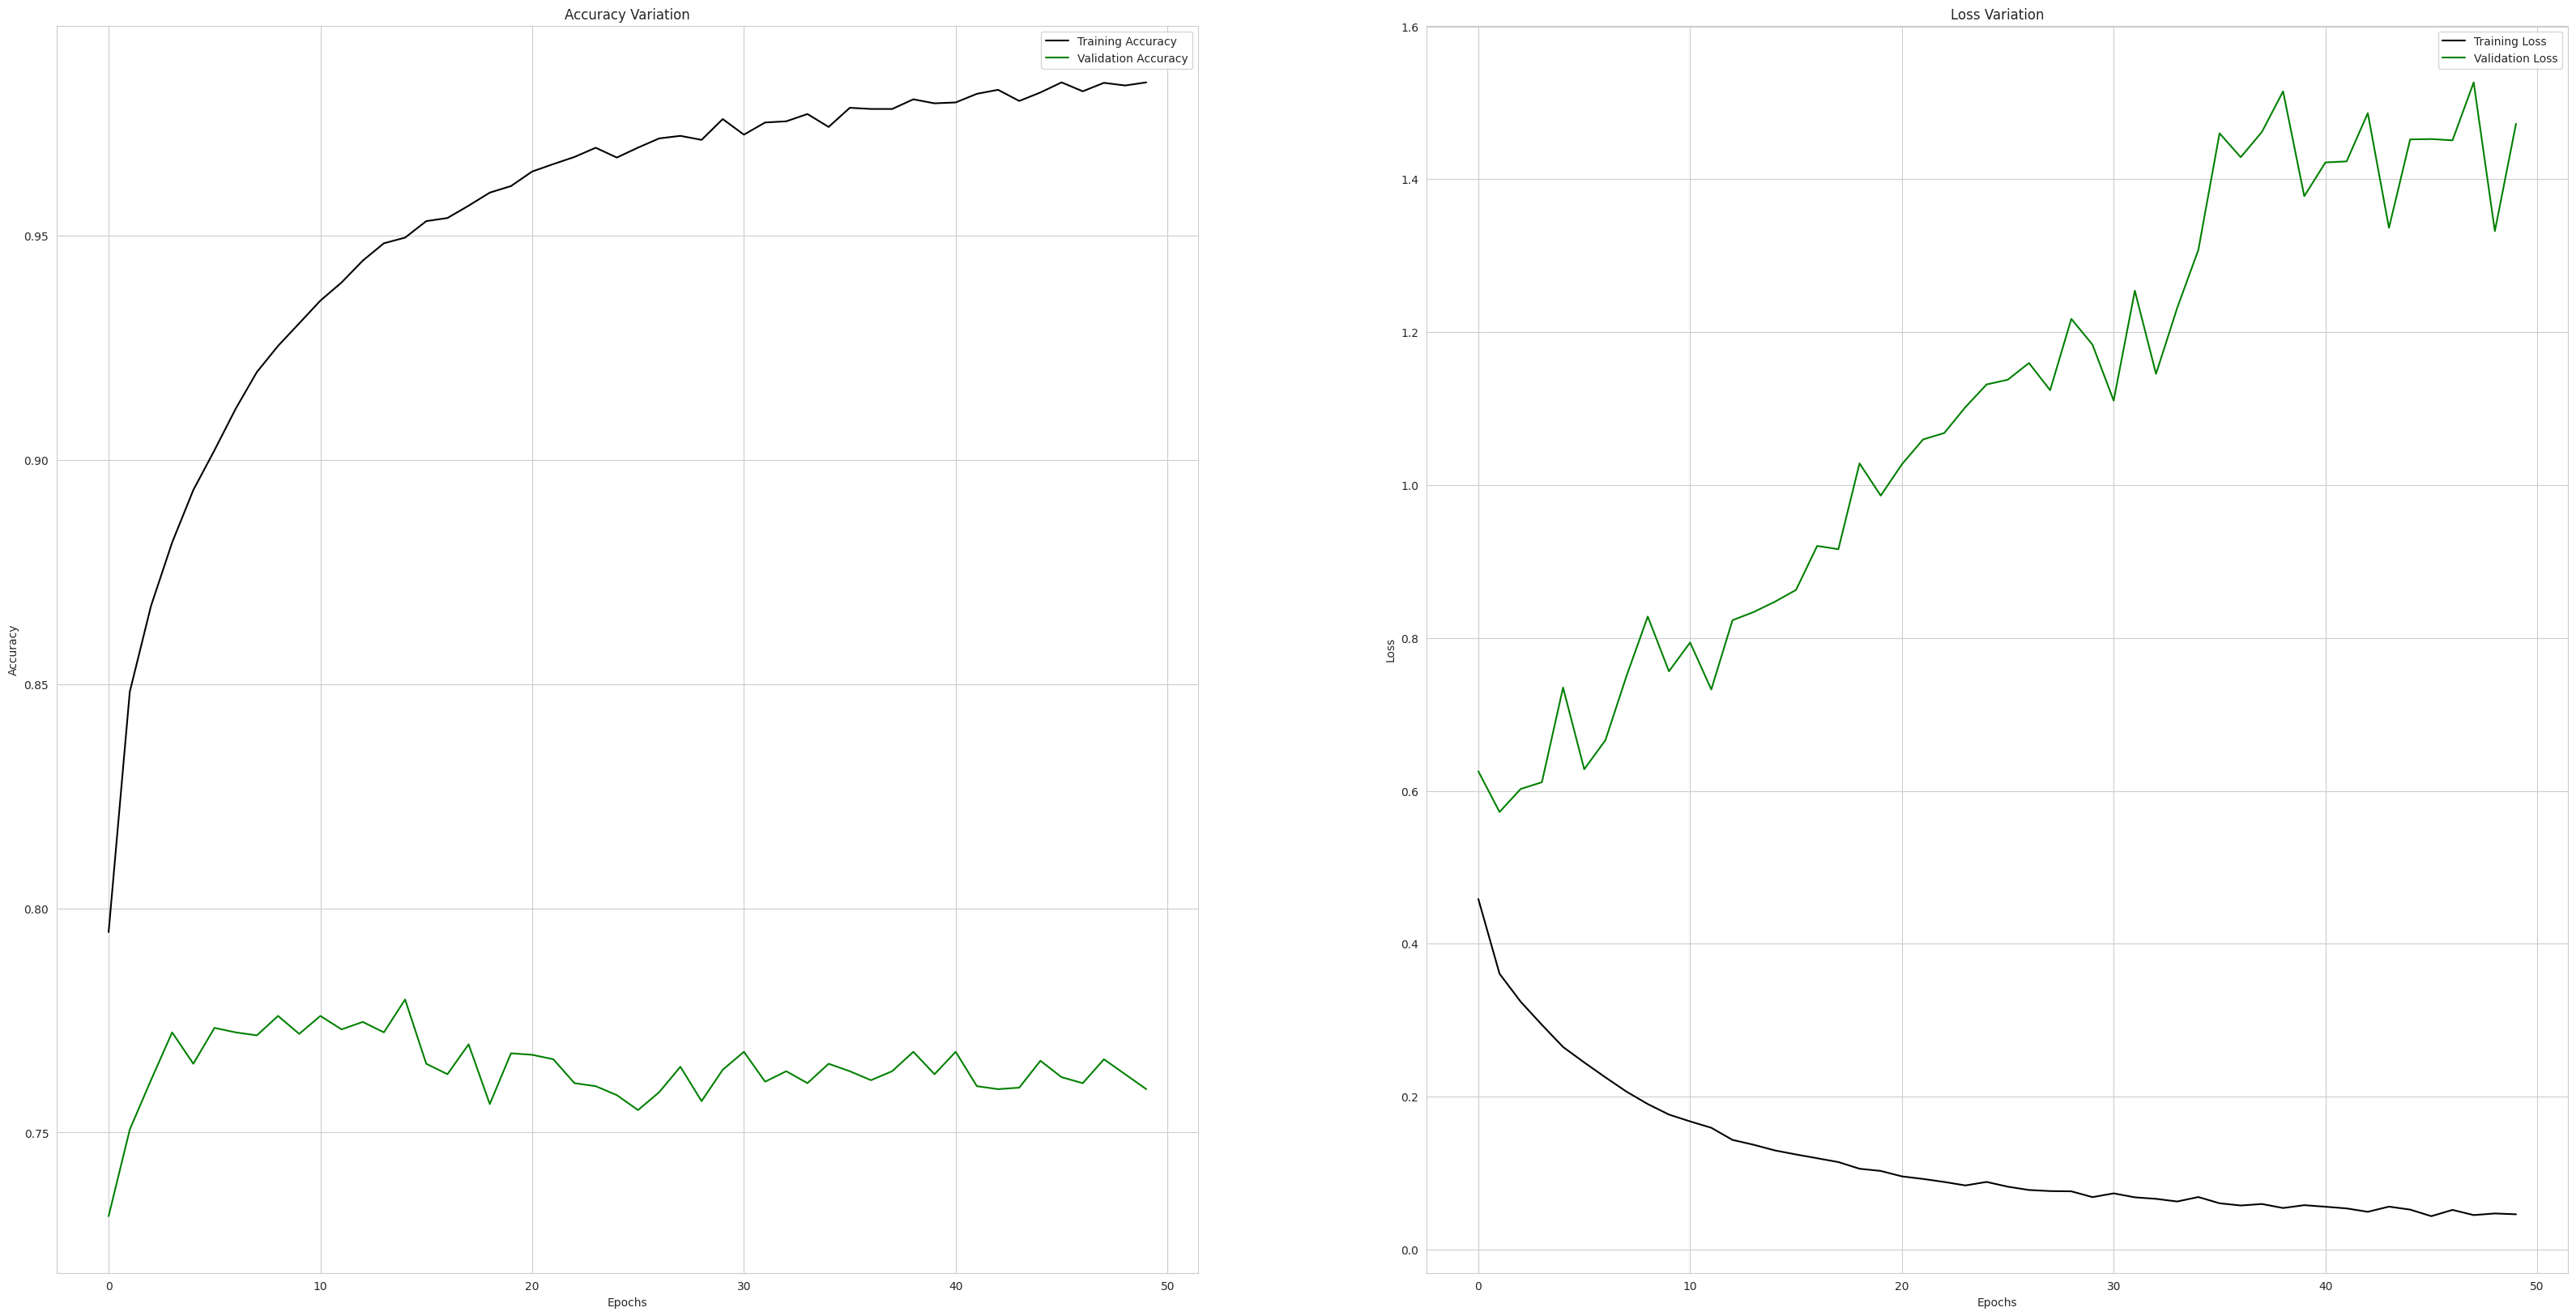

In [ ]:
fig,ax = plt.subplots(figsize = (40,20), ncols = 2)
ax[0].plot(history.history['accuracy'],color = 'black', label = 'Training Accuracy')
ax[0].plot(history.history['val_accuracy'],color = 'green', label = 'Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Accuracy Variation')
ax[0].legend()

ax[1].plot(history.history['loss'],color = 'black', label = 'Training Loss')
ax[1].plot(history.history['val_loss'],color = 'green', label = 'Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Loss Variation')
ax[1].legend()
plt.show()

In [ ]:
from sklearn.linear_model import SGDClassifier
model_8 = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.5, l1_ratio=0.5)
model_8.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  self._get_learning_rate_type(self.learning_rate)


SGDClassifier(alpha=0.5, l1_ratio=0.5, loss='log', penalty='elasticnet')

In [ ]:
y_pred_8 = model_8.predict(X_test)
metrics_8 = test_results(model_8, 5)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  self._get_learning_rate_type(self.learning_rate)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  self._get_learning_rate_type(self.learning_rate)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no p

In [ ]:
model_list = {
    "XGBoost" : pd.Series(metrics_1),
    "Logistic_Regression" : pd.Series(metrics_2),
    "SVM_Linear" : pd.Series(metrics_3),
    "SVM_Polynomial" : pd.Series(metrics_4),
    "SVM_RBF" : pd.Series(metrics_5),
    "Random_Forest" : pd.Series(metrics_6),
    "ANN" : pd.Series(metrics_7),
    "SGD_Elastic_Net" : pd.Series(metrics_8),
}

pd.DataFrame(model_list).T


accuracy  precision_weighted  recall_weighted  \
XGBoost              0.776667            0.770703         0.776667   
Logistic_Regression  0.736667            0.727405         0.736667   
SVM_Linear           0.743333            0.733990         0.743333   
SVM_Polynomial       0.689333            0.684766         0.689333   
SVM_RBF              0.741000            0.730633         0.741000   
Random_Forest        0.765667            0.759637         0.765667   
ANN                  0.781333            0.786204         0.781333   
SGD_Elastic_Net      0.666667            0.444444         0.666667   

                     f1_weighted  
XGBoost                 0.770813  
Logistic_Regression     0.728863  
SVM_Linear              0.734713  
SVM_Polynomial          0.611593  
SVM_RBF                 0.723572  
Random_Forest           0.751333  
ANN                     0.761195  
SGD_Elastic_Net         0.533333

<ipython-input-100-348da9139f1a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')


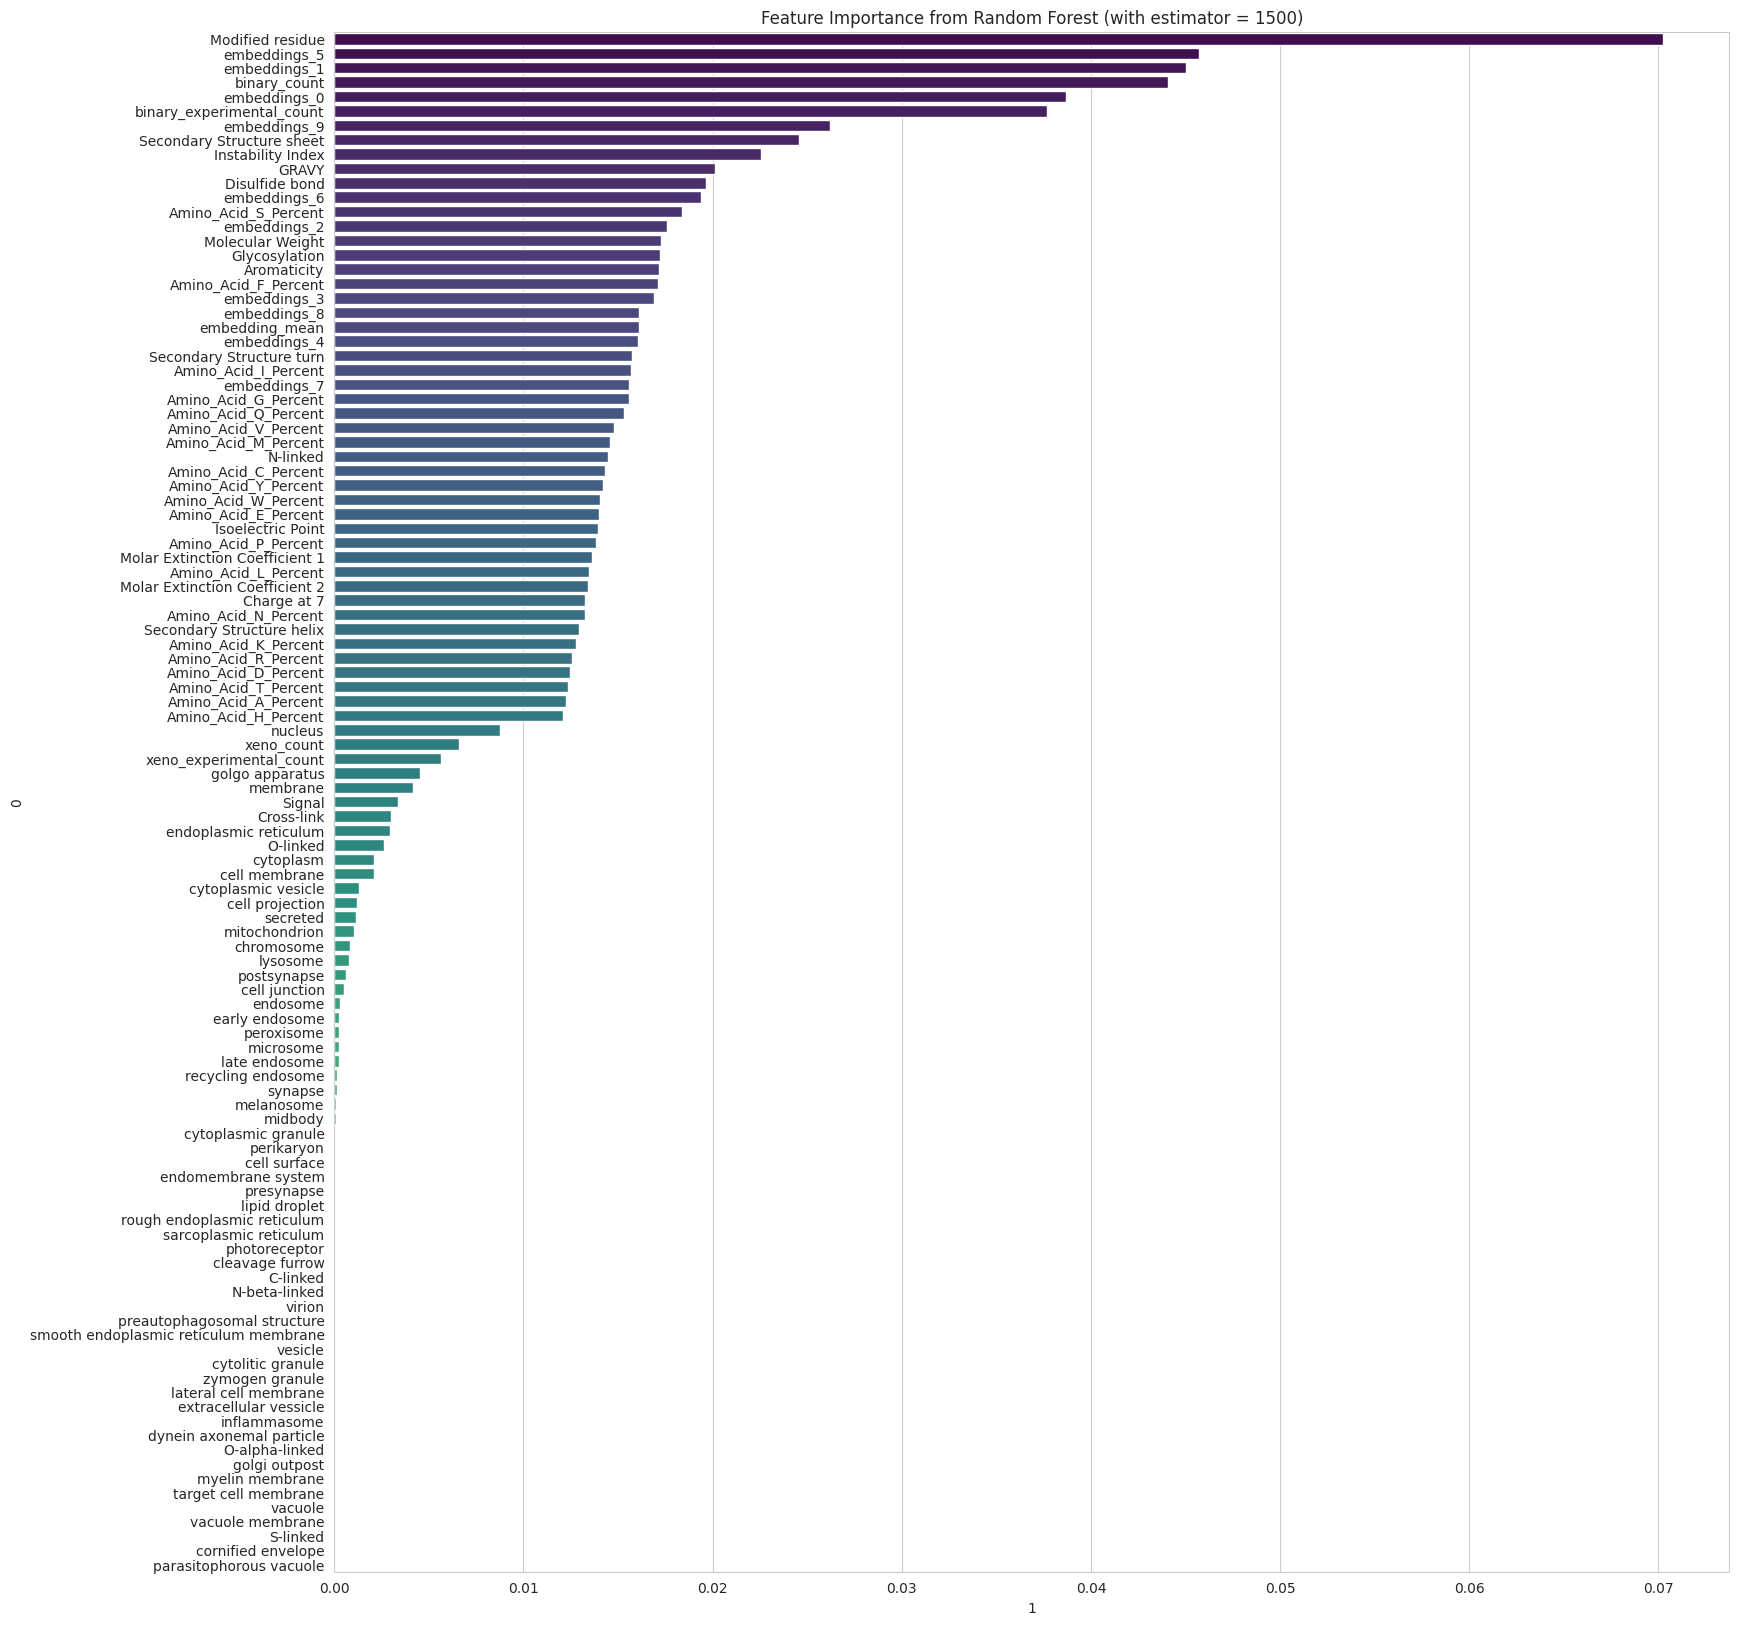

In [ ]:
feature_importance = model_6.feature_importances_
okk = pd.DataFrame([x_sample.columns, feature_importance]).T
okk = okk.sort_values(by = 1,ascending = False)
plt.figure(figsize=(18, 20))
sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')
plt.title("Feature Importance from Random Forest (with estimator = 1500)")
plt.show()

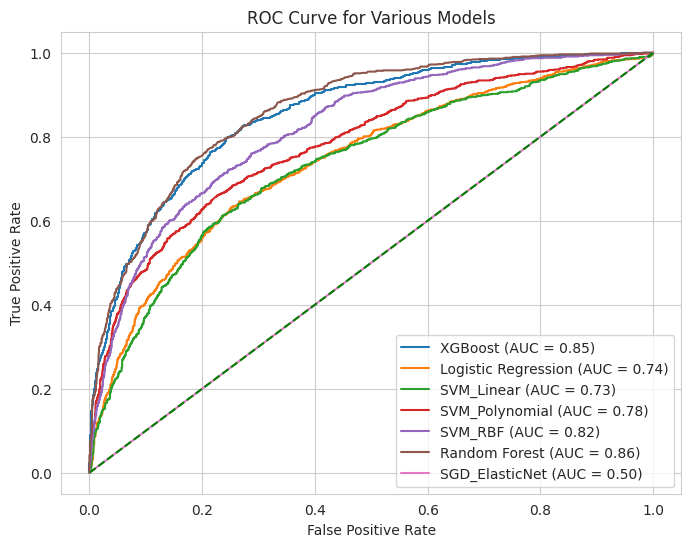

In [ ]:
#roc-auc curve for various algorithm
fpr_1, tpr_1, _ = roc_curve(y_test, model_1.predict_proba(X_test)[:, 1])
fpr_2, tpr_2, _ = roc_curve(y_test, model_2.predict_proba(X_test)[:, 1])
fpr_3, tpr_3, _ = roc_curve(y_test, model_3.predict_proba(X_test)[:, 1])
fpr_4, tpr_4, _ = roc_curve(y_test, model_4.predict_proba(X_test)[:, 1])
fpr_5, tpr_5, _ = roc_curve(y_test, model_5.predict_proba(X_test)[:, 1])
fpr_6, tpr_6, _ = roc_curve(y_test, model_6.predict_proba(X_test)[:, 1])
fpr_8, tpr_8, _ = roc_curve(y_test, model_8.predict_proba(X_test)[:, 1])

from sklearn.metrics import roc_auc_score

auc_1 = roc_auc_score(y_test, model_1.predict_proba(X_test)[:, 1])
auc_2 = roc_auc_score(y_test, model_2.predict_proba(X_test)[:, 1])
auc_3 = roc_auc_score(y_test, model_3.predict_proba(X_test)[:, 1])
auc_4 = roc_auc_score(y_test, model_4.predict_proba(X_test)[:, 1])
auc_5 = roc_auc_score(y_test, model_5.predict_proba(X_test)[:, 1])
auc_6 = roc_auc_score(y_test, model_6.predict_proba(X_test)[:, 1])
auc_8 = roc_auc_score(y_test, model_8.predict_proba(X_test)[:, 1])

# Plot ROC curves for each model with AUC values in the legend
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, label=f'XGBoost (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'Logistic Regression (AUC = {auc_2:.2f})')
plt.plot(fpr_3, tpr_3, label=f'SVM_Linear (AUC = {auc_3:.2f})')
plt.plot(fpr_4, tpr_4, label=f'SVM_Polynomial (AUC = {auc_4:.2f})')
plt.plot(fpr_5, tpr_5, label=f'SVM_RBF (AUC = {auc_5:.2f})')
plt.plot(fpr_6, tpr_6, label=f'Random Forest (AUC = {auc_6:.2f})')
plt.plot(fpr_8, tpr_8, label=f'SGD_ElasticNet (AUC = {auc_8:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Various Models')
plt.legend()
plt.show()

In [ ]:
# import copy

# def evaluate_classifier(features, labels):
#     X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
#     clf = RandomForestClassifier(n_estimators=100, random_state=42)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     return accuracy_score(y_test, y_pred)

# def evaluate_feature_set(feature_set, dataset):
#     features = dataset[feature_set]
#     labels = dataset['is_druggable']
#     return evaluate_classifier(features, labels)

# def evaluate_best_feature_subset(C, S, D):
#     return evaluate_feature_set(S, D)

# def update_feature_subset(S, best_feature):
#     S.append(best_feature)

# def iwssr(D, C, F):
#     best_feature_subset = []
#     best_feature_subset_score = 0

#     for i in range(len(F)):
#         best = None
#         if len(best_feature_subset) == 0:
#             S_sel = [F[i]]
#             feature_score = evaluate_feature_set(S_sel, D)
#             if feature_score > best_feature_subset_score:
#                 best = F[i]
#                 best_feature_subset_score = feature_score
#         else:
#             for j in range(len(best_feature_subset)):
#                 S_sel = copy.deepcopy(best_feature_subset)
#                 S_sel[j] = F[i]
#                 feature_score = evaluate_feature_set(S_sel, D)

#                 if feature_score > best_feature_subset_score:
#                     best = F[i]
#                     best_feature_subset_score = feature_score

#         if best is not None:
#             best_feature_subset.append(best)

#     return best_feature_subset

# # Example usage:
# # Assume dataset is a pandas DataFrame containing features and labels
# # D = dataset
# # C = RandomForestClassifier
# # F = list of features

# best_features = iwssr(okk_1, RandomForestClassifier(), list(okk_1.columns[:-1]))
# print("Best feature subset:", best_features)
